In [1]:
import pandas as pd # data manipulation
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np #  mathematical support for large, multi-dimensional arrays and matrices
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
import re
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from matplotlib.patches import Arc
import math
import xgboost
import dtreeviz


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ekx9jc6v because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

# allDone()


### Set Directory

In [3]:
os.getcwd()

'/scratch/interns202010/jmakins/jupyter-dir'

In [4]:
try:
    os.chdir('/group/interns202010/jmakins/Data')
except:
    pass

In [5]:
Teams = pd.read_json('teams.json')
#Competitions = pd.read_json('competitions.json')
Players = pd.read_json('players.json')
#Coaches = pd.read_json('coaches.json') # Managers

In [6]:
try:
    os.chdir('/group/interns202010/jmakins/Data/matches')
except:
    pass
England = pd.read_json('matches_England.json')
France = pd.read_json('matches_France.json')
Italy = pd.read_json('matches_Italy.json')
Spain = pd.read_json('matches_Spain.json')
Germany = pd.read_json('matches_Germany.json')
#World_Cup = pd.read_json('matches_World_Cup.json')
#Euro_Champs = pd.read_json('matches_European_Championship.json')

In [7]:
# Adding country labels to match observations
England['Country'] = 'England'
France['Country'] = 'France'
Italy['Country'] = 'Italy'
Spain['Country'] = 'Spain'
Germany['Country'] = "Germany"
#World_Cup['Country'] = 'World Cup'
#Euro_Champs['Country'] = 'European Champs'

In [8]:
try:
    os.chdir('/group/interns202010/jmakins/Data/events')
except:
    pass

In [9]:

### WHen USING KAGGLE

# os.chdir('/kaggle/input/football-event-data')

# Teams = pd.read_json('teams.json')
# Competitions = pd.read_json('competitions.json')
# Players = pd.read_json('players.json')
# Coaches = pd.read_json('coaches.json') # Managers

# England = pd.read_json('matches_England.json')
# France = pd.read_json('matches_France.json')
# Italy = pd.read_json('matches_Italy.json')
# Spain = pd.read_json('matches_Spain.json')
# Germany = pd.read_json('matches_Germany.json')

# England['Country'] = 'England'
# France['Country'] = 'France'
# Italy['Country'] = 'Italy'
# Spain['Country'] = 'Spain'
# Germany['Country'] = "Germany"

In [10]:
Events_France = pd.read_json('events_France.json')
Events_Spain = pd.read_json('events_Spain.json')
Events_Germany = pd.read_json('events_Germany.json')
#Events_EuroChamps = pd.read_json('events_European_Championship.json')
#Events_World_Cup = pd.read_json('events_World_Cup.json')
Events_Italy = pd.read_json('events_Italy.json')
Events_England = pd.read_json('events_England.json')

### Data Cleaning

In [11]:
Matches = pd.concat([England, France, Italy, Spain, Germany], ignore_index=True)

In [12]:
Matches.drop(['duration'], inplace=True, axis =1) # removing groupName variable from World Cups

In [13]:
Players.drop(["passportArea"], inplace = True, axis = 1)

In [14]:
Players = Players.rename(columns ={'wyId': 'playerId'}) # rename for convenience

In [15]:
Teams = Teams.rename(columns = {'wyId': 'teamId'})
Players = Players.rename(columns = {'currentTeamId': 'teamId'})
Players = pd.merge(Players,Teams[['teamId', 'officialName']], on = 'teamId').rename(columns = {'officialName': 'clubName'})

In [16]:
Players['Position'] = Players.role.apply(pd.Series)['code3'].values

In [17]:
Players['birthCountry'] = Players.birthArea.apply(pd.Series)['name'].values

In [18]:
Players.drop(["birthArea", 'role'], inplace = True, axis = 1)

### Manipulate Match Data

In [19]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match

In [20]:
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for x in teams:
    homeTeam.append(x[0])
    awayTeam.append(x[1])

In [21]:
# add columns for additional match statistics
Matches["homeManagerId"] = None
for name in ["Score", "ScoreHT", "ScoreET", "ScoreP"]:
    colname = "home" + name
    colname2 = "away" + name
    Matches[colname] = None
    Matches[colname2] = None

In [22]:
# parse Home and Away teams as features from nest dictionary
teams = [list(x.keys()) for x in Matches.teamsData] # create two columns for identifying teams in match
homeTeam, awayTeam = [],[]
for game, team in enumerate(teams):
    if Matches.teamsData[game:game+1][game][team[0]]['side'] == 'home':
        homeTeam.append(team[0])
        awayTeam.append(team[1])
    else:
        awayTeam.append(team[0])
        homeTeam.append(team[1])

In [23]:
def get_team_stats(df, team): # function to parse team match stats from dictionary embedded in column teamsData from the Matches dataframe
    
    Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId = [],[],[],[],[],[],[],[]
    
    for game in range(0, len(df)):

        Bench.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['bench'])['playerId']))
        Starters.append(list(pd.DataFrame.from_dict(df.teamsData[game][team[game]]['formation']['lineup'])['playerId']))
        Manager.append(df.teamsData[game][team[game]]['coachId'])
        Score.append(df.teamsData[game][team[game]]['score'])
        ScoreHT.append(df.teamsData[game][team[game]]['scoreHT'])
        ScoreET.append(df.teamsData[game][team[game]]['scoreET'])
        ScoreP.append(df.teamsData[game][team[game]]['scoreP'])
        teamId.append(df.teamsData[game][team[game]]['teamId'])
    
    return Bench, Starters, Manager, Score, ScoreHT, ScoreET, ScoreP, teamId

homeBench, homeStarters, homeManager, homeScore, homeScoreHT, homeScoreET, homeScoreP, homeTeamId = get_team_stats(Matches, homeTeam)
awayBench, awayStarters, awayManager, awayScore, awayScoreHT, awayScoreET, awayScoreP, awayTeamId = get_team_stats(Matches, awayTeam)


In [24]:
# Automating Bench Line Up Column Generation

homeColNames = []
for num in range(1,14): # add columns for home bench playerId
     homeColNames.append("homeBenchPlayer" + str(num))
        
awayColNames = []
for num in range(1,14): # add columns for away bench playerId
    awayColNames.append("awayBenchPlayer" + str(num))
    


In [25]:
# Inspecting bench counts as during errror handling reveals some matches had bench sizes of between 8 and 13 for certain fixtures
import collections
collections.Counter(list(map(lambda x: len(x), homeBench)))

Counter({7: 1425, 6: 18, 5: 1, 8: 5, 12: 205, 10: 49, 11: 101, 9: 21, 13: 1})

In [26]:
# Adding Bench Line Ups to DataFrame

homeBench2 = pd.DataFrame(homeBench,
     columns=homeColNames)
awayBench2 = pd.DataFrame(awayBench,
     columns=awayColNames)


In [27]:
# Automating Starting Line Up Column Generation

homeColNames =[]
for num in range(1,12): # add columns for starting playerId
     homeColNames.append("homePlayer" + str(num))
        
awayColNames = []
for num in range(1,12): # add columns for starting playerId
    awayColNames.append("awayPlayer" + str(num))


In [28]:
# Joining starting line ups, benches to matches dataframe

homeStarters2 = pd.DataFrame(homeStarters,
     columns=homeColNames)
awayStarters2 = pd.DataFrame(awayStarters,
     columns=awayColNames)

Matches = Matches.join([homeStarters2, awayStarters2, homeBench2, awayBench2])


In [29]:
# add individual columns of match data
Matches['homeManager'] = homeManager
Matches['homeScore'] = homeScore
Matches['homeScoreHT'] = homeScoreHT
Matches['homeScoreET'] = homeScoreET
Matches['homeScoreP'] = homeScoreP
Matches['homeTeamId'] = homeTeamId
Matches['awayManager'] = awayManager
Matches['awayScore'] = awayScore
Matches['awayScoreHT'] = awayScoreHT
Matches['awayScoreET'] = awayScoreET
Matches['awayScoreP'] = awayScoreP
Matches['awayTeamId'] = awayTeamId

In [30]:
Matches.drop(["teamsData"], inplace = True, axis = 1)

In [31]:
# Classify Match Result as W, L or D for teams
conditions = [
    (Matches['winner'] == 0),
    (Matches['winner'] == Matches['awayTeamId']),
    (Matches['winner'] == Matches['homeTeamId'])
    ]

# create a list of the values we want to assign for each condition
values = [0, -1, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
Matches['Result'] = np.select(conditions, values)

In [32]:
Matches["date"] = pd.to_datetime(Matches['dateutc']).dt.date # create a date column for Matches dataframe

In [33]:
Matches["time"] = pd.to_datetime(Matches['dateutc']).dt.time # create a time column for Matches dataframe

In [34]:
# Prelim Dimensionality Reduction
cols2Drop = ['status', 'roundId', 'gameweek', 'dateutc', 'label', 'referees', 'homeManagerId', 'seasonId']
Matches.drop(cols2Drop, inplace=True, axis =1)
Matches.drop(['winner', 'date', 'time'], inplace = True, axis =1)

In [35]:
Matches.rename(columns={'wyId':'matchId'}, inplace=True)

In [36]:
Matches = Matches.fillna(0) # fill bench7players with Ids = 0 in order to prevent program crashing

### Events Manipulation for Match/Player Stats and then combine with existing Match(test) dataframe from aboves

In [37]:
# Decroos Github
tags = [
    (101, "goal"),
    (102, "own_goal"),
    (301, "assist"),
    (302, "key_pass"),
    (1901, "counter_attack"),
    (401, "left_foot"),
    (402, "right_foot"),
    (403, "head/body"),
    (1101, "direct"),
    (1102, "indirect"),
    (2001, "dangerous_ball_lost"),
    (2101, "blocked"),
    (801, "high"),
    (802, "low"),
    (1401, "interception"),
    (1501, "clearance"),
    (201, "opportunity"),
    (1301, "feint"),
    (1302, "missed_ball"),
    (501, "free_space_right"),
    (502, "free_space_left"),
    (503, "take_on_left"),
    (504, "take_on_right"),
    (1601, "sliding_tackle"),
    (601, "anticipated"),
    (602, "anticipation"),
    (1701, "red_card"),
    (1702, "yellow_card"),
    (1703, "second_yellow_card"),
    (1201, "position_goal_low_center"),
    (1202, "position_goal_low_right"),
    (1203, "position_goal_mid_center"),
    (1204, "position_goal_mid_left"),
    (1205, "position_goal_low_left"),
    (1206, "position_goal_mid_right"),
    (1207, "position_goal_high_center"),
    (1208, "position_goal_high_left"),
    (1209, "position_goal_high_right"),
    (1210, "position_out_low_right"),
    (1211, "position_out_mid_left"),
    (1212, "position_out_low_left"),
    (1213, "position_out_mid_right"),
    (1214, "position_out_high_center"),
    (1215, "position_out_high_left"),
    (1216, "position_out_high_right"),
    (1217, "position_post_low_right"),
    (1218, "position_post_mid_left"),
    (1219, "position_post_low_left"),
    (1220, "position_post_mid_right"),
    (1221, "position_post_high_center"),
    (1222, "position_post_high_left"),
    (1223, "position_post_high_right"),
    (901, "through"),
    (1001, "fairplay"),
    (701, "lost"),
    (702, "neutral"),
    (703, "won"),
    (1801, "accurate"),
    (1802, "not_accurate"),
]

In [38]:
tags = dict(tags)

In [39]:
# ## I have kept this cell encase we need to impute integers for ML algorithms as oppose to strings
# event_tag_ids = []
# for ids in  list(trial[0:10]['tags']):
#     event_tag_ids.append(list(map(lambda y: y['id'], ids)))
# trial['event_tag_ids'] = event_tag_ids

In [40]:
# Store event type tags ids in new column
def event_tags(event_df):
    event_tags = []
    for ids in list(event_df['tags']):
        event_tags.append(list(map(lambda y: tags[y['id']], ids)))

    event_df['event_tags'] = event_tags
    return event_df

In [41]:
def RunningTime(event_df):
    # Solution to convert second half time into 
    secs_to_add = list(event_df[event_df['matchPeriod']=="1H"].groupby('matchId').tail(1)['eventSec'])
    match_ids = list(event_df["matchId"].unique())

    for idx in range(0, len(match_ids)):
        event_df['eventSec'] = list(np.where(
           (event_df['matchId'] == match_ids[idx]) & (event_df['matchPeriod'] == "2H") , event_df['eventSec'] + secs_to_add[idx], event_df['eventSec']
           ))
    return event_df


In [42]:
# Clean the result of the action
def Result(event_df):
    result = []
    for tag in event_df["event_tags"]:
        if "accurate" in tag:
            result.append("Accurate")
        elif "not_accurate" in tag:
            result.append("Inaccurate")
        else:
            result.append("")
    event_df["Result"] = result 
    return event_df

In [43]:
# Separating description from success/failure of an action (event)
def event_description(event_df):
    subEventDescr = []
    for tag in event_df["event_tags"]:
        descr = " ".join(tag[:-1])
        if descr != "":
            subEventDescr.append(descr)
        else:
            subEventDescr.append("generic play")
    event_df["subEventDescription"] = subEventDescr
    event_df = event_df[(event_df["event_tags"].str.len() != 0) & (event_df.subEventName != 'Ball out of the field')  & (event_df.subEventName != 'Goal kick')  ]
    event_df = event_df[event_df["subEventName"] != "Throw in"] # remove throw-ins as a relevant feature among successful teams for simpler analysis, unless its Rory Delap!
    return event_df

In [44]:
# # Separating description from success/failure of an action (event)
# def event_description(event_df):
#     subEventDescr = []
#     for tag in event_df["event_tags"]:
#         descr = " ".join(tag[:-1])
#         if descr != "":
#             subEventDescr.append(descr)
#         else:
#             subEventDescr.append("generic play")
#     event_df["subEventDescription"] = subEventDescr
#     event_df = event_df[(event_df["event_tags"].str.len() != 0) & (event_df.subEventName != 'Ball out of the field')  & (event_df.subEventName != 'Goal kick') & (event_df.subEventName != 'Touch')   ]
#     event_df = event_df[event_df["subEventName"] != "Throw in"] # remove throw-ins as a relevant feature among successful teams for simpler analysis, unless its Rory Delap!
#     return event_df

In [45]:

def Locations(event_df):

    xStart,xEnd,yStart,yEnd = [], [], [], []
    for pos in event_df["positions"]:
        if len(pos) == 2:
            xStart.append(pos[0]['x'])
            xEnd.append(pos[1]['x'])
            yStart.append(pos[0]['y'])
            yEnd.append(pos[1]['y'])
        else:
            xStart.append(pos[0]['x'])
            xEnd.append(pos[0]['x'])
            yStart.append(pos[0]['y'])
            yEnd.append(pos[0]['y'])


    event_df['xStart'], event_df['xEnd'], event_df['yStart'], event_df['yEnd'] = xStart, xEnd, yStart, yEnd
    return event_df

In [46]:
# function to transform an event data frame
def event_df_transform(event_df):
    event_df = event_tags(event_df)
    event_df = Result(event_df)
    event_df = event_description(event_df)
    event_df = Locations(event_df)
    event_df.drop(['positions', "event_tags", "tags", "eventName"], inplace = True, axis = 1) #'id'
    event_df = event_df[event_df.subEventName != ""]
    event_df = event_df[event_df['playerId']!= 0]
    event_df = RunningTime(event_df)
    event_df['attackMetres'] = event_df['xEnd'] - event_df['xStart']
    return event_df

# stopped remove eventId
    

In [47]:
# Transform event_dfs

Events_France = event_df_transform(Events_France)
Events_Spain = event_df_transform(Events_Spain)
Events_Germany = event_df_transform(Events_Germany)
Events_Italy = event_df_transform(Events_Italy)
Events_England = event_df_transform(Events_England)


In [48]:
def zones(event_df, start_or_end):

    conditions = [
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <= 36))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 36)& (event_df['y'+ start_or_end] <= 64))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 64)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
        
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <=  25))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <=  75))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <=  100))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] >= 0))& (event_df['y'+ start_or_end] <=  25)),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <=  75))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <=  100))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <= 50))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
        
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 25) & (event_df['y'+ start_or_end] <=  36))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 36) & (event_df['y'+ start_or_end] <= 64))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 64) & (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 75) & (event_df['y'+ start_or_end] <= 100)))
            ]

    # create a list of the values we want to assign for each condition
    values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]

    # create a new column and us np.select to assign values to it using our lists as arguments
    event_df['Zone'+ start_or_end] = np.select(conditions, values)
    
    return event_df



        

In [49]:
for event_df in [Events_England, Events_Italy, Events_Spain, Events_France, Events_Germany]:
    event_df = zones(event_df, "Start")
    event_df = zones(event_df, "End")

In [50]:
### CHange German row with 101
Events_Germany.loc[Events_Germany.yEnd==101, ['yEnd']] = 99

In [51]:
### remove events where playerId equals zero
## There are two instances where goals are scored so we will handle these first and assign to correct players as these are important events
# we can attempt to handle these into the real player sequences if we have time at the end of the project


In [52]:
# function to determine average player coordinates on pitch across all possessions in a match
def playerPosition(event_df):
    df = event_df.groupby(['matchId','playerId']).agg({'xStart': ['mean'], 'yStart': ['mean']}).reset_index()
    df.columns = ["matchId", "playerId", "xStart", "yStart"]
    return df

In [53]:

# find positions for all players for big 5 Euro leagues
a = playerPosition(Events_England)
b = playerPosition(Events_France)
c = playerPosition(Events_Italy)
d = playerPosition(Events_Spain)
e = playerPosition(Events_Germany)

position_df = pd.concat([a,b,c,d,e])


In [54]:

# This dataframe is used relationally to fill correct team as events represent 2018 team, while player
a = Events_England[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
b = Events_France[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
c = Events_Italy[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
d = Events_Spain[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
e = Events_Germany[['playerId', "teamId", 'matchId']].groupby(['playerId', "teamId", 'matchId']).count().reset_index()
p_refs = pd.concat([a,b,c,d,e])


In [55]:

# Create PA dataframe
Player_Aggs = Players[['shortName','Position', 'playerId','weight','height',  'foot' ]]

# add ave field locations to players
Player_Aggs = pd.merge(Player_Aggs, position_df, how = 'right', on= 'playerId').sort_values('matchId')
Player_Aggs = pd.merge(Player_Aggs, p_refs, on = ['matchId', 'playerId'])
Player_Aggs = pd.merge(Player_Aggs, Teams[['teamId', 'name']], on = 'teamId')
Player_Aggs = pd.merge(Player_Aggs, Matches[['matchId', 'homeTeamId', 'awayTeamId']], on = 'matchId')
Player_Aggs.loc[Player_Aggs.teamId == Player_Aggs.homeTeamId, 'homeAway'] = "home"
Player_Aggs.loc[Player_Aggs.teamId == Player_Aggs.awayTeamId, 'homeAway'] = "away"


In [56]:
# # # # # #

# var = "Shot"
# varName = "ShotsOnTarget"

# # this exists
# df = Events_England.loc[(Events_England.Result == "Accurate" ) & (Events_England.subEventName== var )].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotsOnTarget')#.groupby(["matchId",'playerId']).agg(list).reset_index()
# # [['playerId', 'matchId', "ZoneStart"]]
# # # # # # # 

def transform_zonal(df, varName):

    df = df.pivot_table(varName, ['playerId', 'matchId'], 'ZoneStart').fillna(0).reset_index()

    column_indices = []
    new_names = []
    check_cols = list(range(1,27))
    old_columns = list(df.columns[2:])

    for num, col in enumerate(old_columns):
        column_indices.append(num+2)
        new_names.append(varName+ "_ZoneS_" + str(col))

    # columns to be added 
    change_cols = np.setdiff1d(check_cols, old_columns) 

    old_names = df.columns[column_indices]
    df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

    for col in change_cols:
        df[varName + "_ZoneS_" + str(col)] = 0

    return df




In [57]:
### unique entry dataframe for player gameTime at any point in a match by summarizing streams

def playerGameTime(event_df):
    df = event_df.groupby(['matchId','playerId'])['eventSec'].agg(['max', 'min']).reset_index()
    df['gameTime (min)'] = round((df['max'] - df['min'])/60) # game time to the nearest minute
    df.drop(['max', 'min'], inplace=True, axis=1)
    return df

# derive gameTime per player and store in summary table
a = playerGameTime(Events_England)
b = playerGameTime(Events_France)
c = playerGameTime(Events_Italy)
d = playerGameTime(Events_Spain)
e = playerGameTime(Events_Germany)

playingTime = pd.concat([a,b,c,d,e]).fillna(0)


In [58]:
def find_goals(event_df):

    # Create a column to recognize when a goal is scored
    conditions = [
        (((event_df['subEventDescription'].str.match('goal ')) & (event_df['Result'] == "Accurate"))),
        (((event_df['subEventDescription'].str.match('goal ')) & (event_df['Result'] == "Inaccurate") & (event_df['subEventName'] == "Shot"))),
        (((event_df['subEventDescription'].str.match('goal ')) & (event_df['Result'] == "Inaccurate") & (event_df['subEventName'] != "Shot")))
        ]

    # create a list of the values we want to assign for each condition
    values = [1, 1, -1]

    # create a new column and use np.select to assign values to it using our lists as arguments
    event_df['Goal_Value'] = np.select(conditions, values, default = 0)
    #[['playerId', 'matchId', "ZoneStart"]].groupby(['playerId', 'matchId', "ZoneStart"])
    return event_df.groupby(['playerId', 'matchId', "ZoneStart"]).sum().reset_index()#[['playerId', 'matchId', 'Goal_Value']]

In [59]:
for event in [Events_England, Events_Italy, Events_France, Events_Germany, Events_Spain]:
    event = find_goals(event)


In [60]:
Player_Aggs = pd.merge(Player_Aggs, playingTime, how = 'left', on = ['playerId', 'matchId'])

In [61]:
# convenience function for event_df parsing
def parseEvent_df(func, new_feature):
    
    aa = func(Events_England)
    aa = transform_zonal(aa, new_feature)
#     aa = aa.rename_axis(None, axis=1)
    bb = func(Events_France)
    bb = transform_zonal(bb, new_feature)
#     bb = bb.rename_axis(None, axis=1)
    cc = func(Events_Italy)
    cc = transform_zonal(cc, new_feature)
#     cc = cc.rename_axis(None, axis=1)
    dd = func(Events_Spain)
    dd = transform_zonal(dd, new_feature)
#     dd = dd.rename_axis(None, axis=1)
    ee = func(Events_Germany)
    ee = transform_zonal(ee, new_feature)
#     ee = ee.rename_axis(None, axis=1)
    
    return pd.concat([aa,bb,cc,dd,ee])

In [62]:
# function for adding new feature column to Player_Aggs df
def alter_Player_Aggs(new_feature_function, new_feature, PA_df):
    
    if "Acc" in new_feature:
        df = parseEvent_df(new_feature_function, new_feature)
        #df = transform_zonal(df, new_feature)
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
#         new_cols = [col for col in df if col.startswith(new_feature)]
#         PA_df[new_cols] = PA_df[new_cols].fillna(0)
        
    elif 'acc' in new_feature:
        df = parseEvent_df(new_feature_function, new_feature)
        #df = transform_zonal(df, new_feature)
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
#         new_cols = [col for col in df if col.startswith(new_feature)]
#         PA_df[new_cols] = PA_df[new_cols].fillna(0)
        
    else:
        df = parseEvent_df(new_feature_function, new_feature)
        #df = transform_zonal(df, new_feature)
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
#         new_cols = [col for col in df if col.startswith(new_feature)]
#         PA_df[new_cols] = PA_df[new_cols].fillna(0)
        
#         PA_df[new_cols] = (PA_df[new_cols] / PA_df['gameTime (min)']) * 90 # get standardized stat index for 90mins
    PA_df.iloc[:,15:] = PA_df.iloc[:,15:].fillna(0)
    return PA_df


In [63]:
# import datetime
# while datetime.datetime.now().hour < 17:
#     x = 1+1

In [64]:
# calc angle to goal from any location in radians

def angleToGoal(event_df):
    
    event_df['C'] = 10 # length of goal
    event_df['A'] = ((100-event_df.xStart)**2+abs(45-event_df.yStart)**2)**.5
    event_df['B'] = ((100-event_df.xStart)**2+abs(55-event_df.yStart)**2)**.5
    event_df['angle_to_goal'] = (event_df['A'] * event_df['A'] + event_df['B'] * event_df['B'] - event_df['C'] * event_df['C'])/(2 * event_df['A'] * event_df['B'])
    event_df['angle_to_goal'] = event_df['angle_to_goal'].apply(lambda row: round(math.radians(math.degrees(math.acos(row))),4))
    # event_df['angle_to_goal'] = event_df['angle_to_goal'].apply(lambda row: round(math.degrees(row),2))
    event_df.drop(['A', "B", "C"], inplace = True, axis=1)
    return event_df
        
Events_England, Events_France = angleToGoal(Events_England), angleToGoal(Events_France)
Events_Germany, Events_Spain = angleToGoal(Events_Germany), angleToGoal(Events_Spain)
Events_Italy = angleToGoal(Events_Italy)


### Function to prepare dataframe for fdnn

In [65]:
# result is event_df

def player_goals(result):
    
    conditions = [
            (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Accurate"))),
            (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Inaccurate") & (result['subEventName'] == "Shot"))),
            (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Inaccurate") & (result['subEventName'] != "Shot")))
            ]

    # create a list of the values we want to assign for each condition
    values = [1, 1, -1]

    # create a new column and us np.select to assign values to it using our lists as arguments
    result['Goal_Value'] = np.select(conditions, values, default = 0)
    
    return result

    

In [66]:
def corner_assists(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.subEventDescription.str.match('assist'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CornerAssists')

def corner_opportunity(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.subEventDescription.str.match('key_pass'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CornerOpportunitiesCreated')

def corner_success(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SuccessfulCorners')

def corner_fail(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FailedCorners')

def corner_assists(event_df):
    return event_df[(event_df.subEventName=="Corner") & (event_df.subEventDescription.str.match('assist'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CornerAssists')


In [67]:
### Attack Metres stat (how many forward metres achieved through events)
def AccBackwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Accurate" ) & (event_df.attackMetres < 0 )].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccBackMetres"})
    df["AccBackMetres"] = df["AccBackMetres"].abs()
    return df

def InaccBackwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Inaccurate") & (event_df.attackMetres < 0 )].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "InaccBackMetres"})
    df["InaccBackMetres"] = df["InaccBackMetres"].abs()
    return df


### Attack Metres stat (how many forward metres achieved through events)
def AccForwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Accurate") & (event_df.attackMetres > 0 )].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccForwardMetres"})
    return df

def InaccForwardMetres(event_df):

    df = event_df.loc[(event_df.Result == "Inaccurate") & (event_df.attackMetres > 0 ) ].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "InaccForwardMetres"})
    return df


In [68]:

# adding in total meterage of accurate and inaccurate movements by players in the vertical plane towards the goal
# AccBackward = parseEvent_df(AccBackwardMetres)
# InaccBackward = parseEvent_df(InaccBackwardMetres)
# AccForward = parseEvent_df(AccForwardMetres)
# InaccForward= parseEvent_df(InaccForwardMetres)

# Player_Aggs = pd.merge(Player_Aggs, AccBackward, how= 'left', on =['playerId', 'matchId'])
# Player_Aggs = pd.merge(Player_Aggs, InaccBackward, how = 'left', on =['playerId', 'matchId'])
# Player_Aggs = pd.merge(Player_Aggs, AccForward, how= 'left', on =['playerId', 'matchId'])
# Player_Aggs = pd.merge(Player_Aggs, InaccForward, how = 'left', on =['playerId', 'matchId'])
# Player_Aggs.AccForwardMetres = Player_Aggs.AccForwardMetres.fillna(0)
# Player_Aggs.InaccForwardMetres = Player_Aggs.InaccForwardMetres.fillna(0)-
# Player_Aggs.AccBackMetres = Player_Aggs.AccBackMetres.fillna(0)
# Player_Aggs.InaccBackMetres = Player_Aggs.InaccBackMetres.fillna(0)


##### Explore Feature

In [69]:
Events_England.subEventName.unique()

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Cross', 'Shot',
       'Reflexes', 'Touch', 'Clearance', 'Free Kick', 'Corner',
       'Hand pass', 'Acceleration', 'Save attempt', 'Free kick cross',
       'Foul', 'Free kick shot', 'Hand foul', 'Violent Foul', 'Protest',
       'Goalkeeper leaving line', 'Late card foul', 'Out of game foul',
       'Penalty', 'Time lost foul', 'Simulation'], dtype=object)

#### Miscellanous 

In [70]:
def SimulationFouls(event_df):
    df = event_df[(event_df.subEventName=="Simulation")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SimulationFouls')
    return df

def Fouls(event_df):
    df= event_df[(event_df.subEventName.str.contains('foul'))| (event_df.subEventName.str.contains('Foul'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FoulsCommited')

    return df

def Clearances(event_df):
    df =  event_df[(event_df.subEventName=="Clearance")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='Clearances')

    return df
    
def AccLaunchMetres(event_df):
    df =  event_df.loc[(event_df.Result == "Accurate") &(event_df.subEventName=="Launch")].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccLaunchMetres"})

    return df
    
def InaccLaunchMetres(event_df):
    df = event_df.loc[(event_df.Result == "Inaccurate") &(event_df.subEventName=="Launch")].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "InaccLaunchMetres"})

    return df

def FreeKickCrossKey(event_df):
    df = event_df[(event_df.subEventName == "Free kick cross")&(event_df.subEventDescription.str.contains("key"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FKKeyCross')

    return df
        
def FreeKickCrossAssists(event_df):
    df = event_df[(event_df.subEventName == "Free kick cross")&(event_df.subEventDescription.str.contains("assist"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FKCrossAssists')
    return df
    
def FreeKickCrossAccuracy(event_df):
    df1= event_df[(event_df.subEventName == "Free kick cross")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FreeKickCrosses')
    df2 = event_df[(event_df.subEventName == "Free kick cross")& (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccFreeKickCrosses')

    return df2


In [71]:
#penaltiesConversion Statistic

def PenaltiesConverted(event_df):
    df1= event_df[(event_df.subEventName == "Penalty")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PenaltiesAttempted')

    df2 = event_df[(event_df.subEventName == "Penalty")& (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PenaltiesScored')

    df1 = pd.merge(df1,df2, how='left', on = ['matchId', 'playerId'])
    df1['PenaltiesScored'] = df1['PenaltiesScored'].fillna(0)
    df1['penaltiesConversion'] = df1['PenaltiesScored'] / df1['PenaltiesAttempted']
    df1.drop(['PenaltiesScored', 'PenaltiesAttempted' ], inplace=True, axis =1)


    return df1


In [72]:
# 'Ground loose ball duel', 'Ground defending duel'
def dangerousOpponentHalfRecoveries(event_df):
    df = event_df[((event_df.subEventDescription.str.contains("won")) | (event_df.subEventDescription.str.contains("interception") & (event_df.Result=="Accurate"))) & (event_df.subEventName!="Ground attacking duel") & (event_df.xEnd > 60)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='dangerousOpponentHalfRecoveries')
    return df
    
def dangerousOwnHalfBallLost(event_df):
    df = event_df[(event_df.Result=="Inaccurate") & (event_df.xEnd<40) & ((event_df.subEventName.str.contains("pass")) | (event_df.subEventName.str.contains("Acceleration")) | (event_df.subEventName.str.contains("Clearance")) | ((event_df.subEventName.str.contains("duel")) &(event_df.subEventName!='Ground defending duel')) | (event_df.subEventName.str.contains("Launch")))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='dangerousOwnHalfBallLost')
    return df
    
    
def dangerousDefDuelsLost(event_df):
    df = event_df[(event_df.Result=="Inaccurate") & (event_df.xEnd<40) & (event_df.subEventName=="Ground defending duel")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='dangerousDefDuelsLost')
    return df


In [73]:
### Step one proportion of low left shots saved

possies = ['low_left', 'mid_left', 'high_left', 'low_center', 'mid_center', 'high_center', 'low_right', 'mid_right', 'high_right']

def GoalKeepingZoneEfficiency(event_df, pos):
    df1= event_df[((event_df.subEventName=="Save attempt") | (event_df.subEventName=="Reflexes")) &(event_df.subEventDescription.str.contains(pos))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='total_'+pos)

    df2 = event_df[((event_df.subEventName=="Save attempt") | (event_df.subEventName=="Reflexes")) &(event_df.subEventDescription.str.contains(pos)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name=pos+'_saves')

    df1 = pd.merge(df1,df2, how='left', on = ['matchId', 'playerId'])
    df1[pos+'_saves'] = df1[pos+'_saves'].fillna(0)
    df1[pos+'_save_efficiency'] = df1[pos+'_saves'] / df1['total_'+pos]
    df1.drop([pos+'_saves', 'total_'+pos], inplace=True, axis =1)
#     df1 = transform_zonal(df1, desiredName)
    return df1


# for pos in possies:
#     a = GoalKeepingZoneEfficiency(Events_England, pos)
#     b = GoalKeepingZoneEfficiency(Events_France, pos)
#     c = GoalKeepingZoneEfficiency(Events_Italy, pos)
#     d = GoalKeepingZoneEfficiency(Events_Spain, pos)
#     e = GoalKeepingZoneEfficiency(Events_Germany, pos)
#     df = pd.concat([a,b,c,d,e])
#     Player_Aggs = pd.merge(Player_Aggs, df, how= 'left', on = ['playerId', 'matchId'])
#     Player_Aggs[ pos + '_save_efficiency'] = Player_Aggs[pos + '_save_efficiency'].fillna(0)
    

In [74]:
# Goals allowed
def goalsAllowed(event_df):
    df = event_df[((event_df.subEventName == "Reflexes")|(Events_England.subEventName == "Save attempt")) & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='goalsAllowed')
#     df = transform_zonal(df, desiredName)
    return df

# Successful save attempt
def Saves(event_df):
    df= event_df[((event_df.subEventName == "Save attempt")|(Events_England.subEventName == "Save attempt"))&(event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GkSaves')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Hand Pass
def SuccessHandPass(event_df):
    df= event_df[(event_df.subEventName == "Hand pass")&(event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateHandPass')
#     df = transform_zonal(df, desiredName)
    return df
# Inaccurate Hand Pass
def FailedHandPass(event_df):
    df = event_df[(event_df.subEventName == "Hand pass")&(event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateHandPass')
#     df = transform_zonal(df, desiredName)
    return df

# GoalKeeper Leaving Line 
def LeavingLine(event_df):
    df = event_df[(event_df.subEventName=="Goalkeeper leaving line")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GKLeavingLineInstance')
#     df = transform_zonal(df, desiredName)
    return df


#### Crosses, Dribbles, Accelerations

In [75]:
# Number of succesful accelerations
def SuccessAccelerations(event_df):
    df = event_df[(event_df.subEventName == 'Acceleration') & (event_df.Result == 'Accurate')].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SuccessfulAccels')
#     df = transform_zonal(df, desiredName)
    return df

# Number of failed accelerations
def FailedAccelerations(event_df):
    df = event_df[(event_df.subEventName == 'Acceleration') & (event_df.Result == 'Inaccurate')].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FailedAccels')
#     df = transform_zonal(df, desiredName)
    return df

# Total acceleration metres
def AccelDistance(event_df):
    df = event_df.loc[(event_df.Result == "Accurate") & (event_df.subEventName=="Acceleration") ].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "CumAccelerationDist"})
#     df = transform_zonal(df, desiredName)
    return df

# Accelerations into final third
def AccelsIntoFinalThird(event_df):
    df= event_df.loc[(event_df.Result == "Accurate") & (event_df.subEventName=="Acceleration") & (event_df.xStart <= 66)  & (event_df.xEnd > 66)].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccelsDistIntoFinal3rd"})
#     df = transform_zonal(df, desiredName)
    return df

# Acceleration within final third
def AccelsWithinFinalThird(event_df):
    df = event_df.loc[(event_df.Result == "Accurate") & (event_df.subEventName=="Acceleration") & (event_df.xStart > 66) ].groupby(['playerId', 'matchId', "ZoneStart"])['attackMetres'].sum().reset_index().rename(columns={'attackMetres': "AccelsDistWithinFinal3rd"})
#     df = transform_zonal(df, desiredName)
    return df


##### Crossing

In [76]:
# cross assists
def crossAssists(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('assist'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CrossAssists')
    df = transform_zonal(df, desiredName)
    return df

# right foot crosses
def RightFootCross(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('right_foot'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='RightFootCross')
#     df = transform_zonal(df, desiredName)
    return df

# left foot crosses
def LeftFootCross(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('left_foot'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='LeftFootCross')
#     df = transform_zonal(df, desiredName)
    return df

# cross key passes
def CrossKeyPasses(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.subEventDescription.str.contains('key_pass'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CrossKeyPass')
#     df = transform_zonal(df, desiredName)
    return df

# accurate crosses
def AccurateCrosses(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccCrosses')
#     df = transform_zonal(df, desiredName)
    return df

# inaccurate crosses
def InaccurateCrosses(event_df):
    df = event_df[(event_df.subEventName == 'Cross') & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccCrosses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate crosses into penalty box
def AccCrossesBox(event_df):
    df = event_df[(event_df.subEventName == 'Cross') 
               & (event_df.Result=="Accurate") 
               & (event_df.xEnd > 82)
               & (event_df.yEnd < 80)
               & (event_df.yEnd > 20)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccCrossesIntoBox')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate crosses into penalty box
def InaccCrossesBox(event_df):
    df = event_df[(event_df.subEventName == 'Cross') 
               & (event_df.Result=="Inaccurate") 
               & (event_df.xEnd > 82)
               & (event_df.yEnd < 80)
               & (event_df.yEnd > 20)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccCrossesIntoBox')
#     df = transform_zonal(df, desiredName)
    return df



#### Tackles & Ground Duels

In [77]:
# Sliding tackles won
def slidingTacklesWon(event_df):
    df = event_df[(event_df.subEventDescription.str.contains("sliding_tackle won"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SlidingTacklesWon')
#     df = transform_zonal(df, desiredName)
    return df

# Sliding tackles lost
def slidingTacklesLost(event_df):
    df = event_df[(event_df.subEventDescription.str.contains("sliding_tackle lost"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SlidingTacklesLost')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Defending Duels Won
def GroundDuelsWon(event_df):
    df = event_df[(event_df.subEventName=="Ground defending duel") & event_df.subEventDescription.str.contains("won")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundDefDuelsWon')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Defending Duels Lost
def GroundDuelsLost(event_df):
    df = event_df[(event_df.subEventName=="Ground defending duel") & event_df.subEventDescription.str.contains("lost")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundDefDuelsLost')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Defensive Anticipations
def GroundDefAnticipations(event_df):
    df = event_df[(event_df.subEventName=="Ground defending duel") & event_df.subEventDescription.str.contains("anticipated")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='DefensiveAnticipations')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Loose Balls Won
def GroundLooseBallsWon(event_df):
    df = event_df[(event_df.subEventName == 'Ground loose ball duel') &(event_df.subEventDescription.str.contains('won'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundLooseBallsWon')
#     df = transform_zonal(df, desiredName)
    return df

# Ground Loose Balls Lost
def GroundLooseBallsLost(event_df):
    df = event_df[(event_df.subEventName == 'Ground loose ball duel') &(event_df.subEventDescription.str.contains('lost'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundLooseBallsLost')
#     df = transform_zonal(df, desiredName)
    return df

# Ground attacking duels won
def GroundAttackDuelsWon(event_df):
    df = event_df[(event_df.subEventName == 'Ground attacking duel') &(event_df.subEventDescription.str.contains('won'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundAttackDuelsWon')
#     df = transform_zonal(df, desiredName)
    return df

# Ground attacking duels lost
def GroundAttackDuelsLost(event_df):
    df = event_df[(event_df.subEventName == 'Ground attacking duel') &(event_df.subEventDescription.str.contains('lost'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='GroundAttackDuelsLost')
#     df = transform_zonal(df, desiredName)
    return df

# Offensive Touches in box
def OffTouchesBox(event_df):
    df = event_df[(event_df.subEventName == 'Touch')
              & (event_df.xStart > 82)
              & (event_df.yStart < 80)
              & (event_df.yStart > 20)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='OffensiveTouchesBox')
#     df = transform_zonal(df, desiredName)
    return df


#### Shots & Goals

In [78]:
# Shots on Target
def ShotsOnTarget(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotsOnTarget')
#     df = transform_zonal(df, desiredName)
    return df

# Shots off Target
def ShotsOffTarget(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotsOffTarget')
#     df = transform_zonal(df, desiredName)
    return df

# Shot opportunity
def shot_opportunities(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.contains("opportunity"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotOpportunities')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate free kick shots
def accFreeKicks(event_df):
    df = event_df[(event_df.subEventName=="Free kick shot") & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FreeKickShotAcc')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate free kick shots
def InaccFreeKicks(event_df):
    df = event_df[(event_df.subEventName=="Free kick shot") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='FreeKickShotInacc')
#     df = transform_zonal(df, desiredName)
    return df

# Did not score penalty
def PenaltyNotGoal(event_df):
    df = event_df[(event_df.subEventName=="Penalty") & (event_df.Result=="Inaccurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PenaltyNotScored')
#     df = transform_zonal(df, desiredName)
    return df

# Goal scored with head/body
def HeaderGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("head"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='Header/Body_Goal')
#     df = transform_zonal(df, desiredName)
    return df    
    
# Goal scored with right foot
def RightFootGoal(event_df): 
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("right_foot"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='RightFootGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Goal scored with left foot
def LeftFootGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("left_foot"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='LeftFootGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Counter Attack Goal
def CounterAttackGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
              & (event_df.subEventDescription.str.contains("counter_attack"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CounterAttackGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Interception Goal
def InterceptionGoal(event_df):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
                & (event_df.subEventDescription.str.contains("interception"))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InterceptionGoal')
#     df = transform_zonal(df, desiredName)
    return df

# Goal positions
def GoalPositions(event_df, pos):
    df = event_df[(event_df.subEventName=="Shot") & (event_df.subEventDescription.str.match("goal "))
                  & (event_df.subEventDescription.str.contains(pos))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='Goal_'+pos)
#     df = transform_zonal(df, desiredName)
    return df

def OwnGoals(event_df):
    df = event_df[event_df.subEventDescription.str.contains("own")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='OwnGoals')
#     df = transform_zonal(df, desiredName)
    return df

def shotAccuracy(event_df):
    df1 = event_df[(event_df.subEventName.str.contains('Shot')) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('Shot')) ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='ShotAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['shotAccuracy'] = df1['ShotAccuracy1'] / df1['ShotAccuracy2']
    df1.drop(['ShotAccuracy1', 'ShotAccuracy2'], inplace=True, axis =1)
#     df1 = transform_zonal(df, desiredName)
    return df1




In [79]:
# # Get positional zones of goals for players

# possies = ['low_left', 'mid_left', 'high_left', 'low_center', 'mid_center', 'high_center', 'low_right', 'mid_right', 'high_right']
# for pos in possies:
#     a = GoalPositions(Events_England, pos)
#     b = GoalPositions(Events_France, pos)
#     c = GoalPositions(Events_Italy, pos)
#     d = GoalPositions(Events_Spain, pos)
#     e = GoalPositions(Events_Germany, pos)
#     df = pd.concat([a,b,c,d,e])
#     Player_Aggs = pd.merge(Player_Aggs, df, how= 'left', on =['playerId', 'matchId'])
#     Player_Aggs["Goal_"+pos] = Player_Aggs["Goal_"+pos].fillna(0)

# Player_Aggs = Player_Aggs.drop_duplicates()


####   Air duel

In [80]:
def AerialDuelsWon(events_df):
    df = Events_England[(Events_England.subEventName=="Air duel") & (Events_England.subEventDescription.str.contains("won"))].groupby(['playerId', 'matchId', 'ZoneStart']).size().reset_index(name='AerialDuelsWon')
#     df = transform_zonal(df, desiredName)
    return df

def AerialDuelsLost(events_df):
    df =  Events_England[(Events_England.subEventName=="Air duel") & (Events_England.subEventDescription.str.contains("lost"))].groupby(['playerId', 'matchId', 'ZoneStart']).size().reset_index(name='AerialDuelsLost')
#     df = transform_zonal(df, desiredName)
    return df


#### Passing

In [81]:
# Accurate forward passes
def acc_forward_pass(event_df):
    df = event_df[(event_df.subEventName=="Simple pass") 
                   & (event_df.attackMetres>0)
                   & (event_df.Result=="Accurate")
                   & (event_df.subEventDescription.str.match('generic play'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateForwardPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate forward passes 
def inacc_forward_passes(event_df):
    df = event_df[(event_df.subEventName=="Simple pass") 
                   & (event_df.attackMetres>0)
                   & (event_df.Result=="Inaccurate")
                   & (event_df.subEventDescription.str.match('generic play'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateForwardPasses')
#     df = transform_zonal(df, desiredName)
    return df

# SuccessfulInterceptions ## when a player intercepts a play and makes a successful subsequent play
def success_intercept(event_df):
    df = event_df[(event_df.Result == 'Accurate')
                   & (event_df.subEventDescription.str.match('interception'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='SuccessfulInterceptions')
#     df = transform_zonal(df, desiredName)
    return df

# CounterAttackInterceptions
def CounterAttackIntercepts(event_df):
    df = event_df[(event_df.subEventDescription.str.match('counter_attack interception'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CounterAttackIntercept')
#     df = transform_zonal(df, desiredName)
    return df

# DangerousBallLostPassing
def dangerous_ball_lost(event_df):
    df = event_df[(event_df.subEventName.str.contains("pass")) 
                   & (event_df.subEventDescription.str.match('dangerous_ball_lost'))].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassLostDangerous')
#     df = transform_zonal(df, desiredName)
    return df

# Counter attack involvements
def CounterAttackInvolvements(event_df):
    df = event_df[(event_df.subEventDescription.str.match('counter_attack')) 
                  & (event_df.Result == 'Accurate') ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='CounterAttackInvolvements')
#     df = transform_zonal(df, desiredName)
    return df

# Total Assists
def total_assists(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('assist')) 
                  & (event_df.Result == 'Accurate') ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='TotalAssists')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate Keypasses
def inacc_key_passes(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('key_pass')) 
                  & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateKeyPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Keypasses
def acc_keypasses(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('key_pass')) 
                  & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateKeyPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Through Passes
def acc_throughs(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('through')) 
                  & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateThroughPasses')
#     df = transform_zonal(df, desiredName)
    return df
# Inaccurate Through Passes
def inacc_throughs(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('through')) 
                  & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateThroughPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Smart Passes 
def acc_smart_passes(event_df):
    df = event_df[(event_df.subEventName.str.match('Smart pass')) 
                  & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccurateSmartPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate Smart Passes 
def inacc_smartPasses(event_df):
    df = event_df[(event_df.subEventName.str.match('Smart pass')) 
                  & (event_df.Result == "Inaccurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccurateSmartPasses')
#     df = transform_zonal(df, desiredName)
    return df

# Through passes into final third
def throughs_into_final(event_df):
    df = event_df[(event_df.subEventDescription.str.contains('through')) 
                  & (event_df.xStart < 67 ) 
                  & (event_df.xEnd > 66 ) 
                 & (event_df.Result == "Accurate") ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccThroughsIntoFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Passes into final third
def accPasses_into_final(event_df):
    df = event_df[ ( event_df.subEventName.str.contains('pass'))
        & (event_df.xStart < 67 ) 
                  & (event_df.xEnd > 66) 
                 & (event_df.Result == "Accurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccPassesIntoFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Passes into final third
def InaccPasses_into_final(event_df):
    df = event_df[ ( event_df.subEventName.str.contains('pass'))
        & (event_df.xStart < 67 ) 
                  & (event_df.xEnd > 66) 
                 & (event_df.Result == "Inaccurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccPassesIntoFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Accurate Passes within final third
def accPasses_within_finalThird(event_df):
    df = event_df[ (event_df.subEventName.str.contains("pass") )
                   & (event_df.xStart > 66 ) 
                  & (event_df.xEnd > 66 ) 
                 & (event_df.Result == "Accurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='AccPassesWithinFinalThird')
#     df = transform_zonal(df, desiredName)
    return df

# Inaccurate Passes within final third   
def inaccPasses_within_finalThird(event_df):
    df = event_df[ (event_df.subEventName.str.contains("pass") )
                   & (event_df.xStart > 66 ) 
                  & (event_df.xEnd > 66) 
                 & (event_df.Result == "Inaccurate")
                & (event_df.Goal_Value != 1)].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='InaccPassesWithinFinalThird')
#     df = transform_zonal(df, desiredName)
    return df


In [82]:
def shortLongPassRatio(event_df):
    event_df['lateralMetres'] = event_df['yEnd']- event_df['yStart']
    df1 = event_df[(event_df.subEventName.str.contains('pass')) & ((event_df.attackMetres)<20) & (abs(event_df.lateralMetres<20)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('pass')) & (((event_df.attackMetres)>20) | (abs(event_df.lateralMetres>20))) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['shortLongPassRatio'] = df1['PassingAccuracy1'] / df1['PassingAccuracy2']
    df1.drop(['PassingAccuracy1', 'PassingAccuracy2'], inplace=True, axis =1)
#     df1 = transform_zonal(df, desiredName)
    return df1

def longPassAccuracy(event_df):
    event_df['lateralMetres'] = event_df['yEnd']- event_df['yStart']
    df1 = event_df[(event_df.subEventName.str.contains('pass')) & ((abs(event_df.attackMetres)>20) | abs(event_df.lateralMetres>20)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('pass')) & ((abs(event_df.attackMetres)>20) | abs(event_df.lateralMetres>20)) ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['longPassAccuracy'] = df1['PassingAccuracy1'] / df1['PassingAccuracy2']
    df1.drop(['PassingAccuracy1', 'PassingAccuracy2'], inplace=True, axis =1)
#     df1 = transform_zonal(df, desiredName)
    return df1

def shortPassAccuracy(event_df):
    event_df['lateralMetres'] = event_df['yEnd']- event_df['yStart']
    df1 = event_df[(event_df.subEventName.str.contains('pass')) & (abs(event_df.attackMetres)<20) & (abs(event_df.lateralMetres<20)) & (event_df.Result=="Accurate")].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy1')
    df2 = event_df[(event_df.subEventName.str.contains('pass'))& (abs(event_df.attackMetres)<20) & (abs(event_df.lateralMetres<20))  ].groupby(['playerId', 'matchId', "ZoneStart"]).size().reset_index(name='PassingAccuracy2')
    df1 = pd.merge(df1,df2, how="left", on=['playerId', 'matchId'])
    df1['shortPassAccuracy'] = df1['PassingAccuracy1'] / df1['PassingAccuracy2']
    df1.drop(['PassingAccuracy1', 'PassingAccuracy2'], inplace=True, axis =1)
    return df1

In [83]:
Events_England["ReceivingPlayer"] = Events_England['playerId'].shift(-1)

#### Live match analysis

In [84]:
liveTimes = []
for time in range(600, 6000, 600):
    liveTimes.append(time)

In [85]:
liveTimes

[600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, 5400]

In [86]:
#### path = os.getcwd()
# Events_England.to_csv(path+'/Events_England_processed')
# Events_France.to_csv(path+'/Events_France_processed')
# Events_Italy.to_csv(path+'/Events_Italy_processed')
# Events_Spain.to_csv(path+'/Events_Spain_processed')
# Events_Germany.to_csv(path+'/Events_Germany_processed')


In [87]:

# Events_England_live = Events_England[Events_England.eventSec <= liveTime]
# Events_France_live = Events_France[Events_France.eventSec <= liveTime]
# Events_Italy_live = Events_Italy[Events_Italy.eventSec <= liveTime]
# Events_Spain_live = Events_Spain[Events_Spain.eventSec <= liveTime]
# Events_Germany_live = Events_Germany[Events_Germany.eventSec <= liveTime]


In [88]:

Player_Aggs_live = Players[['shortName','Position', 'playerId','weight','height',  'foot' ]]
Player_Aggs_live = pd.merge(Player_Aggs_live, position_df, how = 'right', on= 'playerId').sort_values('matchId')
Player_Aggs_live = pd.merge(Player_Aggs_live, p_refs, on = ['matchId', 'playerId'])
Player_Aggs_live = pd.merge(Player_Aggs_live, Teams[['teamId', 'name']], on = 'teamId')
Player_Aggs_live = pd.merge(Player_Aggs_live, Matches[['matchId', 'homeTeamId', 'awayTeamId']], on = 'matchId')
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.homeTeamId, 'homeAway'] = "home"
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.awayTeamId, 'homeAway'] = "away"


In [89]:
def playerGameTime_live(event_df, time):
    df = event_df.groupby(['matchId','playerId'])['eventSec'].agg([ 'min']).reset_index()
    df['liveTime'] = time
    df['gameTime (min)'] = round((df['liveTime'] - df['min'])/60) # game time to the nearest minute
    # Classify Match Result as W, L or D for teams
    conditions = [
        (df['gameTime (min)']  < 1),
        (df['gameTime (min)'] > 0)
        ]

    # create a list of the values we want to assign for each condition
    values = [0, df['gameTime (min)'].max()]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['gameTime (min)'] = np.select(conditions, values)
    
    df.drop(['liveTime', 'min'], inplace=True, axis=1)
    return df



In [90]:
# convenience function for event_df parsing
def parseEvent_df_live(func, new_feature, time, df_England_live, df_France_live, df_Italy_live, df_Spain_live, df_Germany_live):
    
    aa = func(df_England_live)
    aa = transform_zonal(aa, new_feature)
    bb = func(df_France_live)
    bb = transform_zonal(bb, new_feature)
    cc = func(df_Italy_live)
    cc = transform_zonal(cc, new_feature)
    dd = func(df_Spain_live)
    dd = transform_zonal(dd, new_feature)
    ee = func(df_Germany_live)
    ee = transform_zonal(ee, new_feature)
    
    
    try:
        return pd.concat([aa,bb,cc,dd,ee])
    except:
        return None


In [91]:
# function for adding new feature column to Player_Aggs df

def alter_Player_Aggs_live(new_feature_function, new_feature, PA_df, df_England_live, df_France_live, df_Italy_live, df_Spain_live, df_Germany_live):

    df = parseEvent_df_live(new_feature_function, new_feature, time, df_England_live, df_France_live, df_Italy_live, df_Spain_live, df_Germany_live)

    try:
        PA_df = pd.merge(PA_df, df, how= 'left', on =['playerId', 'matchId'])
    
    except:
        return PA_df
    
    return PA_df


In [92]:
Player_Aggs_live = Players[['shortName','Position', 'playerId','weight','height',  'foot' ]]
Player_Aggs_live = pd.merge(Player_Aggs_live, position_df, how = 'right', on= 'playerId').sort_values('matchId')
Player_Aggs_live = pd.merge(Player_Aggs_live, p_refs, on = ['matchId', 'playerId'])
Player_Aggs_live = pd.merge(Player_Aggs_live, Teams[['teamId', 'name']], on = 'teamId')
Player_Aggs_live = pd.merge(Player_Aggs_live, Matches[['matchId', 'homeTeamId', 'awayTeamId']], on = 'matchId')
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.homeTeamId, 'homeAway'] = "home"
Player_Aggs_live.loc[Player_Aggs_live.teamId == Player_Aggs_live.awayTeamId, 'homeAway'] = "away"

In [93]:
# funkies = [AccBackwardMetres, InaccBackwardMetres, AccForwardMetres, InaccForwardMetres, SimulationFouls, Fouls, Clearances, AccLaunchMetres, InaccLaunchMetres, FreeKickCrossKey, FreeKickCrossAccuracy, dangerousOpponentHalfRecoveries, dangerousOwnHalfBallLost, dangerousDefDuelsLost, Saves, LeavingLine, SuccessAccelerations, FailedAccelerations, AccelDistance, AccelsIntoFinalThird, AccelsWithinFinalThird, RightFootCross, LeftFootCross, CrossKeyPasses, AccurateCrosses, InaccurateCrosses, AccCrossesBox, InaccCrossesBox, slidingTacklesWon, slidingTacklesLost, GroundDuelsWon, GroundDuelsLost, GroundDefAnticipations, GroundLooseBallsWon, GroundLooseBallsLost, GroundAttackDuelsWon, GroundAttackDuelsLost, OffTouchesBox, ShotsOnTarget, ShotsOffTarget, shot_opportunities, accFreeKicks, InaccFreeKicks, PenaltyNotGoal, AerialDuelsWon, AerialDuelsLost, inaccPasses_within_finalThird, accPasses_within_finalThird, accPasses_into_final, InaccPasses_into_final, throughs_into_final, inacc_smartPasses, acc_smart_passes, inacc_throughs, acc_throughs, acc_keypasses, inacc_key_passes, CounterAttackInvolvements, dangerous_ball_lost, CounterAttackIntercepts, success_intercept, inacc_forward_passes, acc_forward_pass, corner_assists, corner_opportunity, corner_success, corner_fail]
# var_noms = ["AccBackMetres",  "InaccBackMetres",  "AccForwardMetres",  "InaccForwardMetres",  "SimulationFouls",  "FoulsCommited",  "Clearances",  "AccLaunchMetres",  "InaccLaunchMetres",  "FKKeyCross",  "AccFreeKickCrosses",  "dangerousOpponentHalfRecoveries",  "dangerousOwnHalfBallLost",  "dangerousDefDuelsLost",  "GkSaves", "GKLeavingLineInstance",  "SuccessfulAccels",  "FailedAccels",  "CumAccelerationDist",  "AccelsDistIntoFinal3rd",  "AccelsDistWithinFinal3rd",  "RightFootCross",  "LeftFootCross",  "CrossKeyPass",  "AccCrosses",  "InaccCrosses",  "AccCrossesIntoBox",  "InaccCrossesIntoBox",  "SlidingTacklesWon",  "SlidingTacklesLost",  "GroundDefDuelsWon",  "GroundDefDuelsLost",  "DefensiveAnticipations",  "GroundLooseBallsWon",  "GroundLooseBallsLost",  "GroundAttackDuelsWon",  "GroundAttackDuelsLost",  "OffensiveTouchesBox",  "ShotsOnTarget",  "ShotsOffTarget",  "ShotOpportunities",  "FreeKickShotAcc",  "FreeKickShotInacc",  "PenaltyNotScored",  "AerialDuelsWon",  "AerialDuelsLost",  "InaccPassesWithinFinalThird",  "AccPassesWithinFinalThird",  "AccPassesIntoFinalThird",  "InaccPassesIntoFinalThird",  "AccThroughsIntoFinalThird",  "InaccurateSmartPasses",  "AccurateSmartPasses",  "InaccurateThroughPasses",  "AccurateThroughPasses",  "AccurateKeyPasses",  "InaccurateKeyPasses",  "CounterAttackInvolvements",  "PassLostDangerous",  "CounterAttackIntercept",  "SuccessfulInterceptions",  "InaccurateForwardPasses",  "AccurateForwardPasses",  "CornerAssists",  "CornerOpportunitiesCreated",  "SuccessfulCorners",  "FailedCorners"]
    
    
# for indx in range(len(funkies)):
#     Player_Aggs2 = alter_Player_Aggs(funkies[indx], var_noms[indx], Player_Aggs2)
#     Player_Aggs2 = Player_Aggs2.drop_duplicates()
#     remove_col = [col for col in Player_Aggs2 if col.endswith("_0")]
#     if remove_col:
#         Player_Aggs2.drop(columns = remove_col, inplace=True, axis=1)

# Player_Aggs2 = Player_Aggs2.loc[:, (Player_Aggs2 != 0).any(axis=0)]


In [94]:
# # # Live Match # # #

def get_live_players(player_aggs_live, time):
    
    # derive gameTime per player and store in summary table
    a = playerGameTime_live(Events_England, time)
    b = playerGameTime_live(Events_France, time)
    c = playerGameTime_live(Events_Italy, time)
    d = playerGameTime_live(Events_Spain, time)
    e = playerGameTime_live(Events_Germany, time)

    playingTime_live = pd.concat([a,b,c,d,e])

    player_aggs_live = pd.merge(player_aggs_live, playingTime_live, how = 'left', on = ['playerId', 'matchId'])

    funkies = [AccBackwardMetres, InaccBackwardMetres, AccForwardMetres, InaccForwardMetres, SimulationFouls, Fouls, Clearances, AccLaunchMetres, InaccLaunchMetres, FreeKickCrossKey, FreeKickCrossAccuracy, dangerousOpponentHalfRecoveries, dangerousOwnHalfBallLost, dangerousDefDuelsLost, Saves, LeavingLine, SuccessAccelerations, FailedAccelerations, AccelDistance, AccelsIntoFinalThird, AccelsWithinFinalThird, RightFootCross, LeftFootCross, CrossKeyPasses, AccurateCrosses, InaccurateCrosses, AccCrossesBox, InaccCrossesBox, slidingTacklesWon, slidingTacklesLost, GroundDuelsWon, GroundDuelsLost, GroundDefAnticipations, GroundLooseBallsWon, GroundLooseBallsLost, GroundAttackDuelsWon, GroundAttackDuelsLost, OffTouchesBox, ShotsOnTarget, ShotsOffTarget, shot_opportunities, accFreeKicks, InaccFreeKicks, PenaltyNotGoal, AerialDuelsWon, AerialDuelsLost, inaccPasses_within_finalThird, accPasses_within_finalThird, accPasses_into_final, InaccPasses_into_final, throughs_into_final, inacc_smartPasses, acc_smart_passes, inacc_throughs, acc_throughs, acc_keypasses, inacc_key_passes, CounterAttackInvolvements, dangerous_ball_lost, CounterAttackIntercepts, success_intercept, inacc_forward_passes, acc_forward_pass, corner_assists, corner_opportunity, corner_success, corner_fail]
    var_noms = ["AccBackMetres",  "InaccBackMetres",  "AccForwardMetres",  "InaccForwardMetres",  "SimulationFouls",  "FoulsCommited",  "Clearances",  "AccLaunchMetres",  "InaccLaunchMetres",  "FKKeyCross",  "AccFreeKickCrosses",  "dangerousOpponentHalfRecoveries",  "dangerousOwnHalfBallLost",  "dangerousDefDuelsLost",  "GkSaves", "GKLeavingLineInstance",  "SuccessfulAccels",  "FailedAccels",  "CumAccelerationDist",  "AccelsDistIntoFinal3rd",  "AccelsDistWithinFinal3rd",  "RightFootCross",  "LeftFootCross",  "CrossKeyPass",  "AccCrosses",  "InaccCrosses",  "AccCrossesIntoBox",  "InaccCrossesIntoBox",  "SlidingTacklesWon",  "SlidingTacklesLost",  "GroundDefDuelsWon",  "GroundDefDuelsLost",  "DefensiveAnticipations",  "GroundLooseBallsWon",  "GroundLooseBallsLost",  "GroundAttackDuelsWon",  "GroundAttackDuelsLost",  "OffensiveTouchesBox",  "ShotsOnTarget",  "ShotsOffTarget",  "ShotOpportunities",  "FreeKickShotAcc",  "FreeKickShotInacc",  "PenaltyNotScored",  "AerialDuelsWon",  "AerialDuelsLost",  "InaccPassesWithinFinalThird",  "AccPassesWithinFinalThird",  "AccPassesIntoFinalThird",  "InaccPassesIntoFinalThird",  "AccThroughsIntoFinalThird",  "InaccurateSmartPasses",  "AccurateSmartPasses",  "InaccurateThroughPasses",  "AccurateThroughPasses",  "AccurateKeyPasses",  "InaccurateKeyPasses",  "CounterAttackInvolvements",  "PassLostDangerous",  "CounterAttackIntercept",  "SuccessfulInterceptions",  "InaccurateForwardPasses",  "AccurateForwardPasses",  "CornerAssists",  "CornerOpportunitiesCreated",  "SuccessfulCorners",  "FailedCorners"]
    
    Events_England_live = Events_England[Events_England.eventSec <= time]
    Events_France_live = Events_France[Events_France.eventSec <= time]
    Events_Italy_live = Events_Italy[Events_Italy.eventSec <= time]
    Events_Spain_live = Events_Spain[Events_Spain.eventSec <= time]
    Events_Germany_live = Events_Germany[Events_Germany.eventSec <= time]
    
    for indx in range(len(funkies)):
        player_aggs_live = alter_Player_Aggs_live(funkies[indx], var_noms[indx], player_aggs_live, Events_England_live, Events_France_live, Events_Italy_live, Events_Spain_live, Events_Germany_live)
        player_aggs_live = player_aggs_live.drop_duplicates()
        remove_col = [col for col in player_aggs_live if col.endswith("_0")]
        if remove_col:
            player_aggs_live.drop(columns = remove_col, inplace=True, axis=1)  

    player_aggs_live.iloc[:,15:] = player_aggs_live.iloc[:,15:].fillna(0)
    player_aggs_live.iloc[:,15:] = player_aggs_live.iloc[:,15:].div(player_aggs_live["gameTime (min)"], axis =0).fillna(0)*90
    player_aggs_live = player_aggs_live.loc[:, (player_aggs_live != 0).any(axis=0)]
    
    return player_aggs_live


In [95]:
# Player_Aggs_live10 = get_live_players(Player_Aggs_live, 600)
# Player_Aggs_live20 = get_live_players(Player_Aggs_live, 1200)
# Player_Aggs_live30 = get_live_players(Player_Aggs_live, 1800)
# Player_Aggs_live40 = get_live_players(Player_Aggs_live, 2400)
# Player_Aggs_live50 = get_live_players(Player_Aggs_live, 3000)
# Player_Aggs_live60 = get_live_players(Player_Aggs_live, 3600)
# Player_Aggs_live70 = get_live_players(Player_Aggs_live, 4200)
# Player_Aggs_live80 = get_live_players(Player_Aggs_live, 4800)
# Player_Aggs_live90 = get_live_players(Player_Aggs_live, 5400)



In [96]:
os.chdir('/group/interns202010/jmakins/Data/events')

In [97]:
path = os.getcwd()

# Player_Aggs_live10.to_csv(path+'/Player_Aggs_live10')
# Player_Aggs_live20.to_csv(path+'/Player_Aggs_live20')
# Player_Aggs_live30.to_csv(path+'/Player_Aggs_live30')
# Player_Aggs_live40.to_csv(path+'/Player_Aggs_live40')
# Player_Aggs_live50.to_csv(path+'/Player_Aggs_live50')
# Player_Aggs_live60.to_csv(path+'/Player_Aggs_live60')
# Player_Aggs_live70.to_csv(path+'/Player_Aggs_live70')
# Player_Aggs_live80.to_csv(path+'/Player_Aggs_live80')
# Player_Aggs_live90.to_csv(path+'/Player_Aggs_live90')

Player_Aggs_live10 = pd.read_csv('Player_Aggs_live10')
Player_Aggs_live10.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live20= pd.read_csv('Player_Aggs_live20')
Player_Aggs_live20.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live30= pd.read_csv('Player_Aggs_live30')
Player_Aggs_live30.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live40= pd.read_csv('Player_Aggs_live40')
Player_Aggs_live40.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live50= pd.read_csv('Player_Aggs_live50')
Player_Aggs_live50.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live60= pd.read_csv('Player_Aggs_live60')
Player_Aggs_live60.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live70= pd.read_csv('Player_Aggs_live70')
Player_Aggs_live70.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live80= pd.read_csv('Player_Aggs_live80')
Player_Aggs_live80.drop(["Unnamed: 0"], axis=1, inplace=True)
Player_Aggs_live90= pd.read_csv('Player_Aggs_live90')
Player_Aggs_live90.drop(["Unnamed: 0"], axis=1, inplace=True)

In [98]:
# Events_England = pd.read_csv('eventsEvents_England_processed')
# Events_Italy = pd.read_csv('eventsEvents_Italy_processed')
# Events_Germany = pd.read_csv('eventsEvents_Germany_processed')
# Events_France = pd.read_csv('eventsEvents_France_processed')
# Events_Spain = pd.read_csv('eventsEvents_Spain_processed')

In [99]:
# Player_Aggs_live.to_csv(path+'/Player_Aggs_live.csv')

In [100]:
# Player_Aggs.to_csv(path+"/Player_Aggs.csv")

### fDNN

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from random import seed

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

In [103]:
def Matches_df_fDNN(TAM):
    df2 = TAM.groupby('matchId').agg(list).reset_index()
    df2.drop(["Result","homeTeamId", "awayTeamId", "height", "weight", 'playerId', "xStart", "yStart", "gameTime (min)"], inplace=True, axis=1)

    df4 = pd.concat([df2, pd.DataFrame(df2['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
    df4.drop(["teamId"], inplace=True, axis = 1)
    result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')


    df3 = result.iloc[:,-4:]
    for var in list(result.columns)[1:-4]:

        df3 = pd.concat([df3, pd.DataFrame(result[var].to_list(), columns=["1_" + var, "2_" + var])], axis=1, sort = False)

        # Correctly apply allocate home and away aggregate statistics to correct teams
        df3['home'+var] = (
            np.select(
                condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        df3['away'+var] = (
            np.select(
                condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
                choicelist=[df3["1_" + var], df3["2_" + var]]))

        # # drop useless columns that have been replaced
        df3.drop([ "1_" + var, "2_" + var], inplace = True, axis = 1 )

    df3 = pd.concat([result[['matchId']],df3], axis=1)
    df3 = pd.merge(df3, Matches[["matchId", "Result"]], how ="inner", on='matchId')
    df3.drop(["team1", "team2"], axis=1, inplace=True)

    return df3


In [104]:
# #### TESTING LIVE

# dropcols = ['playerId',
# 'weight','height','xStart','yStart','homeTeamId','awayTeamId','gameTime (min)','penaltiesConversion',
# 'low_left_save_efficiency','mid_left_save_efficiency','high_left_save_efficiency','low_center_save_efficiency',
# 'mid_center_save_efficiency','high_center_save_efficiency','low_right_save_efficiency','mid_right_save_efficiency',
# 'high_right_save_efficiency','shotAccuracy','shortPassAccuracy','longPassAccuracy','shortLongPassRatio',
# 'Result'][0:7]

# dropcols_live =  dropcols[0:7]

# Team_Aggs_Matches = Player_Aggs_live30.groupby(['matchId', 'teamId' ]).sum().reset_index()
# Team_Aggs_Matches.drop(columns = dropcols, inplace=True, axis=1)

# Team_Aggs = Team_Aggs_Matches.groupby(['teamId']).sum().reset_index()
# Team_Aggs.drop(columns = ['matchId'], inplace=True, axis=1)

In [105]:
Team_Aggs_Matches = Player_Aggs_live60.groupby(['matchId', 'teamId' ]).sum().reset_index()
Team_Aggs_Matches = pd.merge(Team_Aggs_Matches, Matches[['matchId', "Result"]], how = 'left', on = 'matchId' )
result = Matches_df_fDNN(Team_Aggs_Matches)

In [106]:
X_all = result.loc[:, ~result.columns.isin(["Result",'teamId', 'matchId', 'homeTeamId', 'awayTeamId', 'gameTime (min)'])]

In [107]:
y_all = result["Result"].values


In [108]:
X_all = X_all.replace([np.inf, -np.inf], np.nan)
X_all = X_all.fillna(X_all.mean())
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)


In [109]:
clf = RandomForestClassifier(n_estimators = 500, random_state=123, max_depth = 5)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=123)

In [110]:
labels = [-1,0,1]
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, labels = labels))
print('accuracy score: {0:.4f}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

          -1       0.69      0.33      0.44       110
           0       0.00      0.00      0.00        93
           1       0.50      0.97      0.66       163

    accuracy                           0.53       366
   macro avg       0.40      0.43      0.37       366
weighted avg       0.43      0.53      0.43       366

accuracy score: 0.5301


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result']))
class_name = list(set(y_test))
print(class_name)

Predicted Result  -1    1
Actual Result            
-1                36   74
 0                11   82
 1                 5  158
[0, 1, -1]


In [112]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)

In [191]:
df_feature_importance = pd.DataFrame(clf.feature_importances_, index=X_all.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)


ValueError: Shape of passed values is (2628, 1), indices imply (1314, 1)

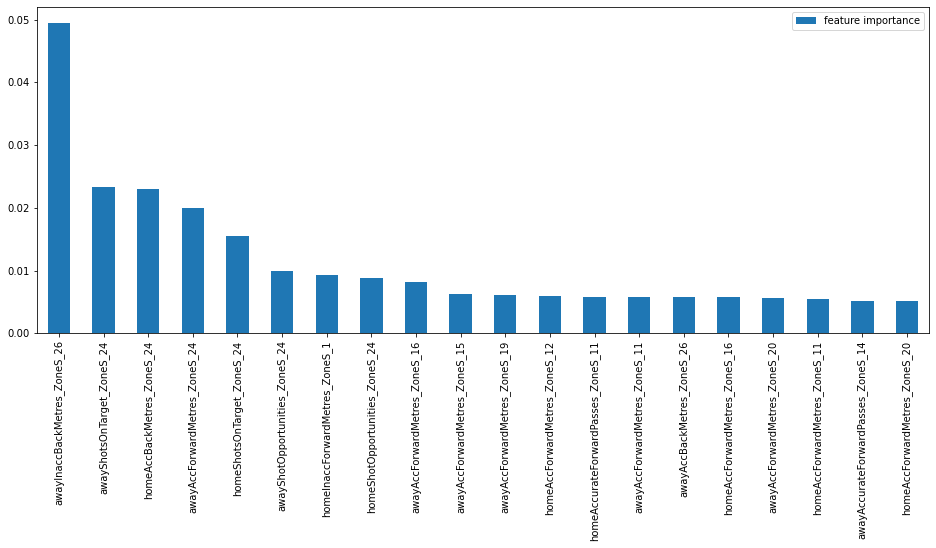

In [114]:
df_feature_importance[0:20].plot(kind='bar');


## fdnn

In [115]:
X_test2 = [tree.predict(X_test) for tree in clf.estimators_]
X_test2 = np.transpose(X_test2)
X_train2 = [tree.predict(X_train) for tree in clf.estimators_]
X_train2 = np.transpose(X_train2)


In [116]:
# x_total = [tree.predict(result) for tree in clf.estimators_]
# x_total = np.transpose(x_total)

In [117]:
def X_transform(X):
    df = []  
    for sample in X:
        s = []
        for feature in sample:
            if feature == 2:
                s.append([0, 0, 1])
            elif feature == 1:
                s.append([0, 1, 0])
            else:
                s.append([1, 0, 0])
        df.append(s)
    df = np.array(df)
    return df

In [118]:
X_train2 = X_transform(X_train2)
X_test2 = X_transform(X_test2)

In [119]:
X_train2.shape
X_test2.shape

(366, 500, 3)

In [120]:
## one-hot encode the labels
def y_transform(Y):
    df = []
    for l in Y:
        if l == 1:
            df.append([0, 0, 1])
        elif l == 0:
            df.append([0, 1, 0])
        else:
            df.append([1, 0, 0])
    df = np.array(df,dtype=int)
    return df

In [121]:
y_train2 = y_transform(y_train)
y_test2 = y_transform(y_test)

In [122]:
print(y_train2.shape)
print(y_test2.shape)

(1460, 3)
(366, 3)


In [163]:
X_train2[[1]]

array([[[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]]])

In [123]:
X_train2, X_test3, y_train2, y_test3 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=123)


In [124]:
print(y_train2.shape)
print(X_train2.shape)


(1168, 3)
(1168, 500, 3)


##### Keras DNN

In [202]:
# Model
def create_model(learn_rate=0.000001, momentum=0):

    model = Sequential()
    model.add(Flatten(input_shape=(500,3)))
    model.add(Dense(256, activation='relu', kernel_initializer = 'he_normal' ,input_shape=(500*3,)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax',kernel_initializer = 'he_normal'))
    #optim = keras.optimizers.SGD(lr=0.01, momentum=0.975, decay=2e-06, nesterov=True)

    opt = keras.optimizers.Adam(learning_rate=learn_rate, momentum=momentum)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


In [203]:
history = model.fit(X_train2, y_train2, validation_data = (X_test3, y_test3), epochs=2000, batch_size=32, verbose =2)

print(model.summary())


Epoch 1/2000
37/37 - 1s - loss: 1.9955 - accuracy: 0.2979 - val_loss: 1.4857 - val_accuracy: 0.2397
Epoch 2/2000
37/37 - 0s - loss: 1.9598 - accuracy: 0.3193 - val_loss: 1.4451 - val_accuracy: 0.2363
Epoch 3/2000
37/37 - 0s - loss: 2.0043 - accuracy: 0.2791 - val_loss: 1.4071 - val_accuracy: 0.2466
Epoch 4/2000
37/37 - 0s - loss: 1.9306 - accuracy: 0.2920 - val_loss: 1.3719 - val_accuracy: 0.2500
Epoch 5/2000
37/37 - 0s - loss: 1.9275 - accuracy: 0.3005 - val_loss: 1.3389 - val_accuracy: 0.2671
Epoch 6/2000
37/37 - 0s - loss: 1.8985 - accuracy: 0.2962 - val_loss: 1.3081 - val_accuracy: 0.2808
Epoch 7/2000
37/37 - 0s - loss: 1.8384 - accuracy: 0.3193 - val_loss: 1.2817 - val_accuracy: 0.2808
Epoch 8/2000
37/37 - 0s - loss: 1.8658 - accuracy: 0.3005 - val_loss: 1.2558 - val_accuracy: 0.2945
Epoch 9/2000
37/37 - 0s - loss: 1.8159 - accuracy: 0.3296 - val_loss: 1.2314 - val_accuracy: 0.3048
Epoch 10/2000
37/37 - 0s - loss: 1.7703 - accuracy: 0.3288 - val_loss: 1.2089 - val_accuracy: 0.3014

Epoch 83/2000
37/37 - 0s - loss: 1.1892 - accuracy: 0.4332 - val_loss: 0.8462 - val_accuracy: 0.6849
Epoch 84/2000
37/37 - 0s - loss: 1.2361 - accuracy: 0.4195 - val_loss: 0.8452 - val_accuracy: 0.6849
Epoch 85/2000
37/37 - 0s - loss: 1.2190 - accuracy: 0.4229 - val_loss: 0.8444 - val_accuracy: 0.6884
Epoch 86/2000
37/37 - 0s - loss: 1.2386 - accuracy: 0.4264 - val_loss: 0.8435 - val_accuracy: 0.6884
Epoch 87/2000
37/37 - 0s - loss: 1.1931 - accuracy: 0.4264 - val_loss: 0.8425 - val_accuracy: 0.6884
Epoch 88/2000
37/37 - 0s - loss: 1.1948 - accuracy: 0.4503 - val_loss: 0.8415 - val_accuracy: 0.6884
Epoch 89/2000
37/37 - 0s - loss: 1.1992 - accuracy: 0.4435 - val_loss: 0.8407 - val_accuracy: 0.6884
Epoch 90/2000
37/37 - 0s - loss: 1.1707 - accuracy: 0.4452 - val_loss: 0.8398 - val_accuracy: 0.6884
Epoch 91/2000
37/37 - 0s - loss: 1.1937 - accuracy: 0.4289 - val_loss: 0.8389 - val_accuracy: 0.6884
Epoch 92/2000
37/37 - 0s - loss: 1.2285 - accuracy: 0.4307 - val_loss: 0.8379 - val_accurac

Epoch 164/2000
37/37 - 0s - loss: 1.0468 - accuracy: 0.5043 - val_loss: 0.7780 - val_accuracy: 0.7123
Epoch 165/2000
37/37 - 0s - loss: 1.0419 - accuracy: 0.4991 - val_loss: 0.7776 - val_accuracy: 0.7123
Epoch 166/2000
37/37 - 0s - loss: 1.0632 - accuracy: 0.4957 - val_loss: 0.7769 - val_accuracy: 0.7123
Epoch 167/2000
37/37 - 0s - loss: 1.0604 - accuracy: 0.5009 - val_loss: 0.7762 - val_accuracy: 0.7158
Epoch 168/2000
37/37 - 0s - loss: 1.0582 - accuracy: 0.4769 - val_loss: 0.7753 - val_accuracy: 0.7123
Epoch 169/2000
37/37 - 0s - loss: 1.0469 - accuracy: 0.5086 - val_loss: 0.7745 - val_accuracy: 0.7158
Epoch 170/2000
37/37 - 0s - loss: 1.0616 - accuracy: 0.4897 - val_loss: 0.7736 - val_accuracy: 0.7089
Epoch 171/2000
37/37 - 0s - loss: 1.0535 - accuracy: 0.4846 - val_loss: 0.7728 - val_accuracy: 0.7123
Epoch 172/2000
37/37 - 0s - loss: 1.0408 - accuracy: 0.4983 - val_loss: 0.7722 - val_accuracy: 0.7123
Epoch 173/2000
37/37 - 0s - loss: 1.0201 - accuracy: 0.5163 - val_loss: 0.7715 - v

Epoch 245/2000
37/37 - 0s - loss: 0.9204 - accuracy: 0.5711 - val_loss: 0.7244 - val_accuracy: 0.7192
Epoch 246/2000
37/37 - 0s - loss: 0.9548 - accuracy: 0.5420 - val_loss: 0.7238 - val_accuracy: 0.7192
Epoch 247/2000
37/37 - 0s - loss: 0.9693 - accuracy: 0.5402 - val_loss: 0.7234 - val_accuracy: 0.7192
Epoch 248/2000
37/37 - 0s - loss: 0.9670 - accuracy: 0.5420 - val_loss: 0.7227 - val_accuracy: 0.7192
Epoch 249/2000
37/37 - 0s - loss: 0.9243 - accuracy: 0.5762 - val_loss: 0.7219 - val_accuracy: 0.7192
Epoch 250/2000
37/37 - 0s - loss: 0.9677 - accuracy: 0.5283 - val_loss: 0.7213 - val_accuracy: 0.7192
Epoch 251/2000
37/37 - 0s - loss: 0.9870 - accuracy: 0.5368 - val_loss: 0.7208 - val_accuracy: 0.7192
Epoch 252/2000
37/37 - 0s - loss: 0.9420 - accuracy: 0.5471 - val_loss: 0.7202 - val_accuracy: 0.7192
Epoch 253/2000
37/37 - 0s - loss: 0.9301 - accuracy: 0.5813 - val_loss: 0.7193 - val_accuracy: 0.7192
Epoch 254/2000
37/37 - 0s - loss: 0.9355 - accuracy: 0.5497 - val_loss: 0.7186 - v

Epoch 326/2000
37/37 - 0s - loss: 0.8811 - accuracy: 0.5899 - val_loss: 0.6760 - val_accuracy: 0.7329
Epoch 327/2000
37/37 - 0s - loss: 0.8851 - accuracy: 0.5899 - val_loss: 0.6756 - val_accuracy: 0.7295
Epoch 328/2000
37/37 - 0s - loss: 0.8912 - accuracy: 0.5830 - val_loss: 0.6753 - val_accuracy: 0.7295
Epoch 329/2000
37/37 - 0s - loss: 0.8879 - accuracy: 0.5762 - val_loss: 0.6748 - val_accuracy: 0.7295
Epoch 330/2000
37/37 - 0s - loss: 0.8820 - accuracy: 0.5822 - val_loss: 0.6741 - val_accuracy: 0.7329
Epoch 331/2000
37/37 - 0s - loss: 0.8588 - accuracy: 0.6147 - val_loss: 0.6735 - val_accuracy: 0.7295
Epoch 332/2000
37/37 - 0s - loss: 0.8851 - accuracy: 0.5771 - val_loss: 0.6729 - val_accuracy: 0.7329
Epoch 333/2000
37/37 - 0s - loss: 0.8711 - accuracy: 0.5993 - val_loss: 0.6723 - val_accuracy: 0.7329
Epoch 334/2000
37/37 - 0s - loss: 0.8863 - accuracy: 0.5993 - val_loss: 0.6718 - val_accuracy: 0.7329
Epoch 335/2000
37/37 - 0s - loss: 0.9167 - accuracy: 0.5642 - val_loss: 0.6713 - v

Epoch 407/2000
37/37 - 0s - loss: 0.8315 - accuracy: 0.6293 - val_loss: 0.6338 - val_accuracy: 0.7432
Epoch 408/2000
37/37 - 0s - loss: 0.8274 - accuracy: 0.6361 - val_loss: 0.6332 - val_accuracy: 0.7432
Epoch 409/2000
37/37 - 0s - loss: 0.8245 - accuracy: 0.6250 - val_loss: 0.6328 - val_accuracy: 0.7432
Epoch 410/2000
37/37 - 0s - loss: 0.8302 - accuracy: 0.6284 - val_loss: 0.6324 - val_accuracy: 0.7432
Epoch 411/2000
37/37 - 0s - loss: 0.8286 - accuracy: 0.6233 - val_loss: 0.6319 - val_accuracy: 0.7466
Epoch 412/2000
37/37 - 0s - loss: 0.8358 - accuracy: 0.6267 - val_loss: 0.6312 - val_accuracy: 0.7466
Epoch 413/2000
37/37 - 0s - loss: 0.8232 - accuracy: 0.6293 - val_loss: 0.6307 - val_accuracy: 0.7466
Epoch 414/2000
37/37 - 0s - loss: 0.8163 - accuracy: 0.6284 - val_loss: 0.6301 - val_accuracy: 0.7466
Epoch 415/2000
37/37 - 0s - loss: 0.8376 - accuracy: 0.6156 - val_loss: 0.6297 - val_accuracy: 0.7466
Epoch 416/2000
37/37 - 0s - loss: 0.8223 - accuracy: 0.6396 - val_loss: 0.6291 - v

Epoch 488/2000
37/37 - 0s - loss: 0.7602 - accuracy: 0.6747 - val_loss: 0.5946 - val_accuracy: 0.7568
Epoch 489/2000
37/37 - 0s - loss: 0.7710 - accuracy: 0.6644 - val_loss: 0.5940 - val_accuracy: 0.7568
Epoch 490/2000
37/37 - 0s - loss: 0.7803 - accuracy: 0.6413 - val_loss: 0.5936 - val_accuracy: 0.7568
Epoch 491/2000
37/37 - 0s - loss: 0.7795 - accuracy: 0.6704 - val_loss: 0.5930 - val_accuracy: 0.7568
Epoch 492/2000
37/37 - 0s - loss: 0.7834 - accuracy: 0.6455 - val_loss: 0.5928 - val_accuracy: 0.7568
Epoch 493/2000
37/37 - 0s - loss: 0.7823 - accuracy: 0.6473 - val_loss: 0.5925 - val_accuracy: 0.7568
Epoch 494/2000
37/37 - 0s - loss: 0.7827 - accuracy: 0.6575 - val_loss: 0.5922 - val_accuracy: 0.7568
Epoch 495/2000
37/37 - 0s - loss: 0.7818 - accuracy: 0.6515 - val_loss: 0.5918 - val_accuracy: 0.7568
Epoch 496/2000
37/37 - 0s - loss: 0.7702 - accuracy: 0.6481 - val_loss: 0.5913 - val_accuracy: 0.7568
Epoch 497/2000
37/37 - 0s - loss: 0.7621 - accuracy: 0.6695 - val_loss: 0.5910 - v

Epoch 569/2000
37/37 - 0s - loss: 0.7264 - accuracy: 0.6866 - val_loss: 0.5606 - val_accuracy: 0.7808
Epoch 570/2000
37/37 - 0s - loss: 0.7377 - accuracy: 0.6695 - val_loss: 0.5601 - val_accuracy: 0.7808
Epoch 571/2000
37/37 - 0s - loss: 0.7085 - accuracy: 0.6926 - val_loss: 0.5596 - val_accuracy: 0.7808
Epoch 572/2000
37/37 - 0s - loss: 0.7266 - accuracy: 0.6678 - val_loss: 0.5592 - val_accuracy: 0.7808
Epoch 573/2000
37/37 - 0s - loss: 0.7396 - accuracy: 0.6807 - val_loss: 0.5589 - val_accuracy: 0.7808
Epoch 574/2000
37/37 - 0s - loss: 0.7671 - accuracy: 0.6678 - val_loss: 0.5586 - val_accuracy: 0.7808
Epoch 575/2000
37/37 - 0s - loss: 0.7185 - accuracy: 0.6747 - val_loss: 0.5581 - val_accuracy: 0.7808
Epoch 576/2000
37/37 - 0s - loss: 0.7259 - accuracy: 0.6781 - val_loss: 0.5576 - val_accuracy: 0.7808
Epoch 577/2000
37/37 - 0s - loss: 0.7342 - accuracy: 0.6772 - val_loss: 0.5573 - val_accuracy: 0.7808
Epoch 578/2000
37/37 - 0s - loss: 0.7444 - accuracy: 0.6627 - val_loss: 0.5570 - v

Epoch 650/2000
37/37 - 0s - loss: 0.6680 - accuracy: 0.7123 - val_loss: 0.5291 - val_accuracy: 0.7945
Epoch 651/2000
37/37 - 0s - loss: 0.7017 - accuracy: 0.6943 - val_loss: 0.5288 - val_accuracy: 0.7945
Epoch 652/2000
37/37 - 0s - loss: 0.6808 - accuracy: 0.7055 - val_loss: 0.5282 - val_accuracy: 0.7945
Epoch 653/2000
37/37 - 0s - loss: 0.6822 - accuracy: 0.7132 - val_loss: 0.5278 - val_accuracy: 0.7945
Epoch 654/2000
37/37 - 0s - loss: 0.6785 - accuracy: 0.6986 - val_loss: 0.5273 - val_accuracy: 0.7945
Epoch 655/2000
37/37 - 0s - loss: 0.6812 - accuracy: 0.7046 - val_loss: 0.5268 - val_accuracy: 0.7945
Epoch 656/2000
37/37 - 0s - loss: 0.6826 - accuracy: 0.7183 - val_loss: 0.5263 - val_accuracy: 0.7945
Epoch 657/2000
37/37 - 0s - loss: 0.7114 - accuracy: 0.6807 - val_loss: 0.5262 - val_accuracy: 0.7945
Epoch 658/2000
37/37 - 0s - loss: 0.6787 - accuracy: 0.7123 - val_loss: 0.5257 - val_accuracy: 0.7945
Epoch 659/2000
37/37 - 0s - loss: 0.6512 - accuracy: 0.7209 - val_loss: 0.5253 - v

Epoch 731/2000
37/37 - 0s - loss: 0.6700 - accuracy: 0.7140 - val_loss: 0.4975 - val_accuracy: 0.8082
Epoch 732/2000
37/37 - 0s - loss: 0.6548 - accuracy: 0.7089 - val_loss: 0.4972 - val_accuracy: 0.8082
Epoch 733/2000
37/37 - 0s - loss: 0.6608 - accuracy: 0.7235 - val_loss: 0.4969 - val_accuracy: 0.8082
Epoch 734/2000
37/37 - 0s - loss: 0.6638 - accuracy: 0.7217 - val_loss: 0.4966 - val_accuracy: 0.8082
Epoch 735/2000
37/37 - 0s - loss: 0.6629 - accuracy: 0.7192 - val_loss: 0.4964 - val_accuracy: 0.8082
Epoch 736/2000
37/37 - 0s - loss: 0.6478 - accuracy: 0.7235 - val_loss: 0.4959 - val_accuracy: 0.8082
Epoch 737/2000
37/37 - 0s - loss: 0.6594 - accuracy: 0.7149 - val_loss: 0.4956 - val_accuracy: 0.8116
Epoch 738/2000
37/37 - 0s - loss: 0.6444 - accuracy: 0.7312 - val_loss: 0.4953 - val_accuracy: 0.8116
Epoch 739/2000
37/37 - 0s - loss: 0.6459 - accuracy: 0.7346 - val_loss: 0.4949 - val_accuracy: 0.8116
Epoch 740/2000
37/37 - 0s - loss: 0.6366 - accuracy: 0.7372 - val_loss: 0.4944 - v

Epoch 812/2000
37/37 - 0s - loss: 0.6126 - accuracy: 0.7483 - val_loss: 0.4663 - val_accuracy: 0.8322
Epoch 813/2000
37/37 - 0s - loss: 0.5751 - accuracy: 0.7646 - val_loss: 0.4657 - val_accuracy: 0.8322
Epoch 814/2000
37/37 - 0s - loss: 0.6127 - accuracy: 0.7346 - val_loss: 0.4654 - val_accuracy: 0.8322
Epoch 815/2000
37/37 - 0s - loss: 0.6214 - accuracy: 0.7457 - val_loss: 0.4651 - val_accuracy: 0.8322
Epoch 816/2000
37/37 - 0s - loss: 0.6116 - accuracy: 0.7509 - val_loss: 0.4648 - val_accuracy: 0.8322
Epoch 817/2000
37/37 - 0s - loss: 0.6162 - accuracy: 0.7380 - val_loss: 0.4645 - val_accuracy: 0.8322
Epoch 818/2000
37/37 - 0s - loss: 0.6304 - accuracy: 0.7354 - val_loss: 0.4642 - val_accuracy: 0.8322
Epoch 819/2000
37/37 - 0s - loss: 0.6061 - accuracy: 0.7517 - val_loss: 0.4638 - val_accuracy: 0.8390
Epoch 820/2000
37/37 - 0s - loss: 0.5988 - accuracy: 0.7594 - val_loss: 0.4634 - val_accuracy: 0.8390
Epoch 821/2000
37/37 - 0s - loss: 0.6035 - accuracy: 0.7483 - val_loss: 0.4631 - v

Epoch 893/2000
37/37 - 0s - loss: 0.5647 - accuracy: 0.7663 - val_loss: 0.4379 - val_accuracy: 0.8493
Epoch 894/2000
37/37 - 0s - loss: 0.5475 - accuracy: 0.7705 - val_loss: 0.4375 - val_accuracy: 0.8493
Epoch 895/2000
37/37 - 0s - loss: 0.5739 - accuracy: 0.7740 - val_loss: 0.4371 - val_accuracy: 0.8493
Epoch 896/2000
37/37 - 0s - loss: 0.5754 - accuracy: 0.7783 - val_loss: 0.4366 - val_accuracy: 0.8493
Epoch 897/2000
37/37 - 0s - loss: 0.5607 - accuracy: 0.7663 - val_loss: 0.4362 - val_accuracy: 0.8493
Epoch 898/2000
37/37 - 0s - loss: 0.5463 - accuracy: 0.7997 - val_loss: 0.4359 - val_accuracy: 0.8493
Epoch 899/2000
37/37 - 0s - loss: 0.5638 - accuracy: 0.7671 - val_loss: 0.4355 - val_accuracy: 0.8493
Epoch 900/2000
37/37 - 0s - loss: 0.5458 - accuracy: 0.7740 - val_loss: 0.4351 - val_accuracy: 0.8493
Epoch 901/2000
37/37 - 0s - loss: 0.5688 - accuracy: 0.7731 - val_loss: 0.4347 - val_accuracy: 0.8493
Epoch 902/2000
37/37 - 0s - loss: 0.5812 - accuracy: 0.7603 - val_loss: 0.4343 - v

Epoch 974/2000
37/37 - 0s - loss: 0.4973 - accuracy: 0.7937 - val_loss: 0.4084 - val_accuracy: 0.8733
Epoch 975/2000
37/37 - 0s - loss: 0.5005 - accuracy: 0.8082 - val_loss: 0.4079 - val_accuracy: 0.8733
Epoch 976/2000
37/37 - 0s - loss: 0.5071 - accuracy: 0.8057 - val_loss: 0.4074 - val_accuracy: 0.8733
Epoch 977/2000
37/37 - 0s - loss: 0.5375 - accuracy: 0.7920 - val_loss: 0.4070 - val_accuracy: 0.8733
Epoch 978/2000
37/37 - 0s - loss: 0.5517 - accuracy: 0.7697 - val_loss: 0.4067 - val_accuracy: 0.8733
Epoch 979/2000
37/37 - 0s - loss: 0.5515 - accuracy: 0.7860 - val_loss: 0.4066 - val_accuracy: 0.8733
Epoch 980/2000
37/37 - 0s - loss: 0.5027 - accuracy: 0.8031 - val_loss: 0.4061 - val_accuracy: 0.8733
Epoch 981/2000
37/37 - 0s - loss: 0.5382 - accuracy: 0.7868 - val_loss: 0.4056 - val_accuracy: 0.8733
Epoch 982/2000
37/37 - 0s - loss: 0.5376 - accuracy: 0.7783 - val_loss: 0.4053 - val_accuracy: 0.8733
Epoch 983/2000
37/37 - 0s - loss: 0.5467 - accuracy: 0.7834 - val_loss: 0.4052 - v

Epoch 1054/2000
37/37 - 0s - loss: 0.5158 - accuracy: 0.7988 - val_loss: 0.3817 - val_accuracy: 0.8870
Epoch 1055/2000
37/37 - 0s - loss: 0.5037 - accuracy: 0.7954 - val_loss: 0.3812 - val_accuracy: 0.8870
Epoch 1056/2000
37/37 - 0s - loss: 0.4914 - accuracy: 0.8151 - val_loss: 0.3808 - val_accuracy: 0.8870
Epoch 1057/2000
37/37 - 0s - loss: 0.4828 - accuracy: 0.8211 - val_loss: 0.3804 - val_accuracy: 0.8870
Epoch 1058/2000
37/37 - 0s - loss: 0.4990 - accuracy: 0.8116 - val_loss: 0.3800 - val_accuracy: 0.8870
Epoch 1059/2000
37/37 - 0s - loss: 0.4825 - accuracy: 0.8134 - val_loss: 0.3796 - val_accuracy: 0.8870
Epoch 1060/2000
37/37 - 0s - loss: 0.4835 - accuracy: 0.8022 - val_loss: 0.3793 - val_accuracy: 0.8870
Epoch 1061/2000
37/37 - 0s - loss: 0.4736 - accuracy: 0.8185 - val_loss: 0.3789 - val_accuracy: 0.8870
Epoch 1062/2000
37/37 - 0s - loss: 0.4759 - accuracy: 0.8279 - val_loss: 0.3782 - val_accuracy: 0.8870
Epoch 1063/2000
37/37 - 0s - loss: 0.4861 - accuracy: 0.8168 - val_loss: 

Epoch 1134/2000
37/37 - 0s - loss: 0.4365 - accuracy: 0.8365 - val_loss: 0.3571 - val_accuracy: 0.8870
Epoch 1135/2000
37/37 - 0s - loss: 0.4467 - accuracy: 0.8339 - val_loss: 0.3567 - val_accuracy: 0.8870
Epoch 1136/2000
37/37 - 0s - loss: 0.4793 - accuracy: 0.8065 - val_loss: 0.3564 - val_accuracy: 0.8870
Epoch 1137/2000
37/37 - 0s - loss: 0.4686 - accuracy: 0.8134 - val_loss: 0.3561 - val_accuracy: 0.8836
Epoch 1138/2000
37/37 - 0s - loss: 0.4586 - accuracy: 0.8193 - val_loss: 0.3557 - val_accuracy: 0.8836
Epoch 1139/2000
37/37 - 0s - loss: 0.4365 - accuracy: 0.8356 - val_loss: 0.3551 - val_accuracy: 0.8836
Epoch 1140/2000
37/37 - 0s - loss: 0.4620 - accuracy: 0.8262 - val_loss: 0.3548 - val_accuracy: 0.8836
Epoch 1141/2000
37/37 - 0s - loss: 0.4478 - accuracy: 0.8373 - val_loss: 0.3545 - val_accuracy: 0.8836
Epoch 1142/2000
37/37 - 0s - loss: 0.4771 - accuracy: 0.8039 - val_loss: 0.3542 - val_accuracy: 0.8836
Epoch 1143/2000
37/37 - 0s - loss: 0.4480 - accuracy: 0.8313 - val_loss: 

Epoch 1214/2000
37/37 - 0s - loss: 0.4024 - accuracy: 0.8459 - val_loss: 0.3331 - val_accuracy: 0.8904
Epoch 1215/2000
37/37 - 0s - loss: 0.4017 - accuracy: 0.8562 - val_loss: 0.3328 - val_accuracy: 0.8904
Epoch 1216/2000
37/37 - 0s - loss: 0.4612 - accuracy: 0.8134 - val_loss: 0.3326 - val_accuracy: 0.8904
Epoch 1217/2000
37/37 - 0s - loss: 0.4399 - accuracy: 0.8253 - val_loss: 0.3323 - val_accuracy: 0.8904
Epoch 1218/2000
37/37 - 0s - loss: 0.4168 - accuracy: 0.8399 - val_loss: 0.3319 - val_accuracy: 0.8904
Epoch 1219/2000
37/37 - 0s - loss: 0.4310 - accuracy: 0.8339 - val_loss: 0.3316 - val_accuracy: 0.8904
Epoch 1220/2000
37/37 - 0s - loss: 0.4238 - accuracy: 0.8408 - val_loss: 0.3314 - val_accuracy: 0.8904
Epoch 1221/2000
37/37 - 0s - loss: 0.4294 - accuracy: 0.8339 - val_loss: 0.3312 - val_accuracy: 0.8904
Epoch 1222/2000
37/37 - 0s - loss: 0.4188 - accuracy: 0.8442 - val_loss: 0.3310 - val_accuracy: 0.8904
Epoch 1223/2000
37/37 - 0s - loss: 0.4167 - accuracy: 0.8408 - val_loss: 

Epoch 1294/2000
37/37 - 0s - loss: 0.4146 - accuracy: 0.8467 - val_loss: 0.3118 - val_accuracy: 0.8973
Epoch 1295/2000
37/37 - 0s - loss: 0.3882 - accuracy: 0.8690 - val_loss: 0.3114 - val_accuracy: 0.8973
Epoch 1296/2000
37/37 - 0s - loss: 0.3877 - accuracy: 0.8570 - val_loss: 0.3110 - val_accuracy: 0.8973
Epoch 1297/2000
37/37 - 0s - loss: 0.3619 - accuracy: 0.8682 - val_loss: 0.3108 - val_accuracy: 0.8973
Epoch 1298/2000
37/37 - 0s - loss: 0.4185 - accuracy: 0.8296 - val_loss: 0.3104 - val_accuracy: 0.8973
Epoch 1299/2000
37/37 - 0s - loss: 0.4044 - accuracy: 0.8373 - val_loss: 0.3099 - val_accuracy: 0.8973
Epoch 1300/2000
37/37 - 0s - loss: 0.3948 - accuracy: 0.8527 - val_loss: 0.3095 - val_accuracy: 0.8973
Epoch 1301/2000
37/37 - 0s - loss: 0.4089 - accuracy: 0.8450 - val_loss: 0.3094 - val_accuracy: 0.8973
Epoch 1302/2000
37/37 - 0s - loss: 0.4022 - accuracy: 0.8485 - val_loss: 0.3092 - val_accuracy: 0.8973
Epoch 1303/2000
37/37 - 0s - loss: 0.4069 - accuracy: 0.8467 - val_loss: 

Epoch 1374/2000
37/37 - 0s - loss: 0.3619 - accuracy: 0.8570 - val_loss: 0.2908 - val_accuracy: 0.9007
Epoch 1375/2000
37/37 - 0s - loss: 0.3672 - accuracy: 0.8793 - val_loss: 0.2907 - val_accuracy: 0.9007
Epoch 1376/2000
37/37 - 0s - loss: 0.3534 - accuracy: 0.8656 - val_loss: 0.2904 - val_accuracy: 0.9007
Epoch 1377/2000
37/37 - 0s - loss: 0.3467 - accuracy: 0.8716 - val_loss: 0.2901 - val_accuracy: 0.9007
Epoch 1378/2000
37/37 - 0s - loss: 0.3670 - accuracy: 0.8656 - val_loss: 0.2898 - val_accuracy: 0.9007
Epoch 1379/2000
37/37 - 0s - loss: 0.3630 - accuracy: 0.8690 - val_loss: 0.2896 - val_accuracy: 0.9007
Epoch 1380/2000
37/37 - 0s - loss: 0.3473 - accuracy: 0.8716 - val_loss: 0.2894 - val_accuracy: 0.9007
Epoch 1381/2000
37/37 - 0s - loss: 0.3815 - accuracy: 0.8690 - val_loss: 0.2891 - val_accuracy: 0.9007
Epoch 1382/2000
37/37 - 0s - loss: 0.3661 - accuracy: 0.8690 - val_loss: 0.2889 - val_accuracy: 0.9007
Epoch 1383/2000
37/37 - 0s - loss: 0.3618 - accuracy: 0.8630 - val_loss: 

Epoch 1454/2000
37/37 - 0s - loss: 0.3463 - accuracy: 0.8784 - val_loss: 0.2721 - val_accuracy: 0.9075
Epoch 1455/2000
37/37 - 0s - loss: 0.3428 - accuracy: 0.8801 - val_loss: 0.2720 - val_accuracy: 0.9075
Epoch 1456/2000
37/37 - 0s - loss: 0.3223 - accuracy: 0.8776 - val_loss: 0.2719 - val_accuracy: 0.9075
Epoch 1457/2000
37/37 - 0s - loss: 0.3325 - accuracy: 0.8878 - val_loss: 0.2717 - val_accuracy: 0.9075
Epoch 1458/2000
37/37 - 0s - loss: 0.3590 - accuracy: 0.8724 - val_loss: 0.2716 - val_accuracy: 0.9075
Epoch 1459/2000
37/37 - 0s - loss: 0.3274 - accuracy: 0.8784 - val_loss: 0.2713 - val_accuracy: 0.9075
Epoch 1460/2000
37/37 - 0s - loss: 0.3125 - accuracy: 0.8827 - val_loss: 0.2710 - val_accuracy: 0.9075
Epoch 1461/2000
37/37 - 0s - loss: 0.3321 - accuracy: 0.8784 - val_loss: 0.2708 - val_accuracy: 0.9075
Epoch 1462/2000
37/37 - 0s - loss: 0.3299 - accuracy: 0.8776 - val_loss: 0.2706 - val_accuracy: 0.9075
Epoch 1463/2000
37/37 - 0s - loss: 0.3364 - accuracy: 0.8733 - val_loss: 

Epoch 1534/2000
37/37 - 0s - loss: 0.3099 - accuracy: 0.8947 - val_loss: 0.2557 - val_accuracy: 0.9075
Epoch 1535/2000
37/37 - 0s - loss: 0.2989 - accuracy: 0.8913 - val_loss: 0.2553 - val_accuracy: 0.9075
Epoch 1536/2000
37/37 - 0s - loss: 0.3019 - accuracy: 0.8913 - val_loss: 0.2550 - val_accuracy: 0.9075
Epoch 1537/2000
37/37 - 0s - loss: 0.2950 - accuracy: 0.8887 - val_loss: 0.2549 - val_accuracy: 0.9075
Epoch 1538/2000
37/37 - 0s - loss: 0.3017 - accuracy: 0.8921 - val_loss: 0.2548 - val_accuracy: 0.9075
Epoch 1539/2000
37/37 - 0s - loss: 0.3313 - accuracy: 0.8776 - val_loss: 0.2546 - val_accuracy: 0.9075
Epoch 1540/2000
37/37 - 0s - loss: 0.3018 - accuracy: 0.8921 - val_loss: 0.2545 - val_accuracy: 0.9075
Epoch 1541/2000
37/37 - 0s - loss: 0.3199 - accuracy: 0.8836 - val_loss: 0.2544 - val_accuracy: 0.9075
Epoch 1542/2000
37/37 - 0s - loss: 0.3024 - accuracy: 0.8964 - val_loss: 0.2541 - val_accuracy: 0.9075
Epoch 1543/2000
37/37 - 0s - loss: 0.3059 - accuracy: 0.8810 - val_loss: 

Epoch 1614/2000
37/37 - 0s - loss: 0.2748 - accuracy: 0.8955 - val_loss: 0.2415 - val_accuracy: 0.9178
Epoch 1615/2000
37/37 - 0s - loss: 0.2916 - accuracy: 0.8955 - val_loss: 0.2413 - val_accuracy: 0.9212
Epoch 1616/2000
37/37 - 0s - loss: 0.3027 - accuracy: 0.8921 - val_loss: 0.2411 - val_accuracy: 0.9212
Epoch 1617/2000
37/37 - 0s - loss: 0.2718 - accuracy: 0.9058 - val_loss: 0.2409 - val_accuracy: 0.9212
Epoch 1618/2000
37/37 - 0s - loss: 0.3002 - accuracy: 0.8896 - val_loss: 0.2408 - val_accuracy: 0.9212
Epoch 1619/2000
37/37 - 0s - loss: 0.2971 - accuracy: 0.8964 - val_loss: 0.2406 - val_accuracy: 0.9212
Epoch 1620/2000
37/37 - 0s - loss: 0.2903 - accuracy: 0.8896 - val_loss: 0.2404 - val_accuracy: 0.9212
Epoch 1621/2000
37/37 - 0s - loss: 0.2800 - accuracy: 0.9118 - val_loss: 0.2402 - val_accuracy: 0.9212
Epoch 1622/2000
37/37 - 0s - loss: 0.2915 - accuracy: 0.9041 - val_loss: 0.2399 - val_accuracy: 0.9212
Epoch 1623/2000
37/37 - 0s - loss: 0.2832 - accuracy: 0.8998 - val_loss: 

Epoch 1694/2000
37/37 - 0s - loss: 0.2913 - accuracy: 0.8938 - val_loss: 0.2294 - val_accuracy: 0.9281
Epoch 1695/2000
37/37 - 0s - loss: 0.2601 - accuracy: 0.9024 - val_loss: 0.2291 - val_accuracy: 0.9281
Epoch 1696/2000
37/37 - 0s - loss: 0.2533 - accuracy: 0.9170 - val_loss: 0.2289 - val_accuracy: 0.9281
Epoch 1697/2000
37/37 - 0s - loss: 0.2524 - accuracy: 0.9118 - val_loss: 0.2287 - val_accuracy: 0.9281
Epoch 1698/2000
37/37 - 0s - loss: 0.2544 - accuracy: 0.9092 - val_loss: 0.2284 - val_accuracy: 0.9281
Epoch 1699/2000
37/37 - 0s - loss: 0.2703 - accuracy: 0.9067 - val_loss: 0.2281 - val_accuracy: 0.9281
Epoch 1700/2000
37/37 - 0s - loss: 0.2593 - accuracy: 0.9212 - val_loss: 0.2278 - val_accuracy: 0.9281
Epoch 1701/2000
37/37 - 0s - loss: 0.2572 - accuracy: 0.9041 - val_loss: 0.2276 - val_accuracy: 0.9281
Epoch 1702/2000
37/37 - 0s - loss: 0.2646 - accuracy: 0.9101 - val_loss: 0.2274 - val_accuracy: 0.9281
Epoch 1703/2000
37/37 - 0s - loss: 0.2492 - accuracy: 0.9161 - val_loss: 

Epoch 1774/2000
37/37 - 0s - loss: 0.2644 - accuracy: 0.9135 - val_loss: 0.2167 - val_accuracy: 0.9384
Epoch 1775/2000
37/37 - 0s - loss: 0.2211 - accuracy: 0.9247 - val_loss: 0.2165 - val_accuracy: 0.9418
Epoch 1776/2000
37/37 - 0s - loss: 0.2463 - accuracy: 0.9135 - val_loss: 0.2165 - val_accuracy: 0.9418
Epoch 1777/2000
37/37 - 0s - loss: 0.2445 - accuracy: 0.9170 - val_loss: 0.2162 - val_accuracy: 0.9384
Epoch 1778/2000
37/37 - 0s - loss: 0.2254 - accuracy: 0.9281 - val_loss: 0.2161 - val_accuracy: 0.9384
Epoch 1779/2000
37/37 - 0s - loss: 0.2326 - accuracy: 0.9195 - val_loss: 0.2162 - val_accuracy: 0.9384
Epoch 1780/2000
37/37 - 0s - loss: 0.2393 - accuracy: 0.9135 - val_loss: 0.2160 - val_accuracy: 0.9384
Epoch 1781/2000
37/37 - 0s - loss: 0.2547 - accuracy: 0.8990 - val_loss: 0.2157 - val_accuracy: 0.9384
Epoch 1782/2000
37/37 - 0s - loss: 0.2597 - accuracy: 0.9135 - val_loss: 0.2157 - val_accuracy: 0.9384
Epoch 1783/2000
37/37 - 0s - loss: 0.2353 - accuracy: 0.9212 - val_loss: 

Epoch 1854/2000
37/37 - 0s - loss: 0.2250 - accuracy: 0.9204 - val_loss: 0.2071 - val_accuracy: 0.9418
Epoch 1855/2000
37/37 - 0s - loss: 0.2139 - accuracy: 0.9307 - val_loss: 0.2072 - val_accuracy: 0.9418
Epoch 1856/2000
37/37 - 0s - loss: 0.2405 - accuracy: 0.9144 - val_loss: 0.2070 - val_accuracy: 0.9418
Epoch 1857/2000
37/37 - 0s - loss: 0.2076 - accuracy: 0.9204 - val_loss: 0.2069 - val_accuracy: 0.9418
Epoch 1858/2000
37/37 - 0s - loss: 0.2162 - accuracy: 0.9255 - val_loss: 0.2068 - val_accuracy: 0.9418
Epoch 1859/2000
37/37 - 0s - loss: 0.2297 - accuracy: 0.9127 - val_loss: 0.2066 - val_accuracy: 0.9418
Epoch 1860/2000
37/37 - 0s - loss: 0.2340 - accuracy: 0.9187 - val_loss: 0.2066 - val_accuracy: 0.9418
Epoch 1861/2000
37/37 - 0s - loss: 0.2071 - accuracy: 0.9375 - val_loss: 0.2066 - val_accuracy: 0.9418
Epoch 1862/2000
37/37 - 0s - loss: 0.2239 - accuracy: 0.9281 - val_loss: 0.2066 - val_accuracy: 0.9418
Epoch 1863/2000
37/37 - 0s - loss: 0.2336 - accuracy: 0.9195 - val_loss: 

Epoch 1934/2000
37/37 - 0s - loss: 0.2148 - accuracy: 0.9255 - val_loss: 0.1972 - val_accuracy: 0.9418
Epoch 1935/2000
37/37 - 0s - loss: 0.2025 - accuracy: 0.9315 - val_loss: 0.1972 - val_accuracy: 0.9418
Epoch 1936/2000
37/37 - 0s - loss: 0.2064 - accuracy: 0.9366 - val_loss: 0.1972 - val_accuracy: 0.9418
Epoch 1937/2000
37/37 - 0s - loss: 0.1783 - accuracy: 0.9461 - val_loss: 0.1970 - val_accuracy: 0.9418
Epoch 1938/2000
37/37 - 0s - loss: 0.2061 - accuracy: 0.9281 - val_loss: 0.1969 - val_accuracy: 0.9418
Epoch 1939/2000
37/37 - 0s - loss: 0.2100 - accuracy: 0.9298 - val_loss: 0.1968 - val_accuracy: 0.9418
Epoch 1940/2000
37/37 - 0s - loss: 0.2149 - accuracy: 0.9255 - val_loss: 0.1966 - val_accuracy: 0.9418
Epoch 1941/2000
37/37 - 0s - loss: 0.2109 - accuracy: 0.9307 - val_loss: 0.1964 - val_accuracy: 0.9418
Epoch 1942/2000
37/37 - 0s - loss: 0.2204 - accuracy: 0.9272 - val_loss: 0.1961 - val_accuracy: 0.9418
Epoch 1943/2000
37/37 - 0s - loss: 0.2274 - accuracy: 0.9212 - val_loss: 

#### Overnight gridsearch

In [ ]:
# model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# # define the grid search parameters
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(epochs=[2000,3000,4000], batch_size=[16,32,64,128,256], learning_rate=[0.01,0.001,0.0001,.00001,0.000001,.0000001,.00000001], )
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X, Y)



In [204]:
y_pred = model.predict(X_test2)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test2)):
    test.append(np.argmax(y_test2[i]))

In [205]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 59.56284153005464


In [206]:
for i in range(len(pred)):
    if pred[i]==2:
        pred[i] = 1
    elif pred[i]==0:
        pred[i]= -1
    else:
        pred[i]=0

In [207]:
for i in range(len(test)):
    if test[i]==2:
        test[i] = 1
    elif test[i]==0:
        test[i]= -1
    else:
        test[i]=0

In [208]:
labels = [-1,0,1]

print(classification_report(test, pred, labels = labels))
print('accuracy score: {0:.4f}'.format(accuracy_score(test,pred)))

              precision    recall  f1-score   support

          -1       0.58      0.64      0.61       110
           0       0.40      0.18      0.25        93
           1       0.65      0.80      0.72       163

    accuracy                           0.60       366
   macro avg       0.54      0.54      0.52       366
weighted avg       0.56      0.60      0.56       366

accuracy score: 0.5956


In [209]:
print(pd.crosstab(np.array(test), np.array(pred), rownames=['Actual Result'], colnames=['Predicted Result']))
class_name = list(set(test))
print(class_name)

Predicted Result  -1   0    1
Actual Result                
-1                70  11   29
 0                33  17   43
 1                18  14  131
[0, 1, -1]


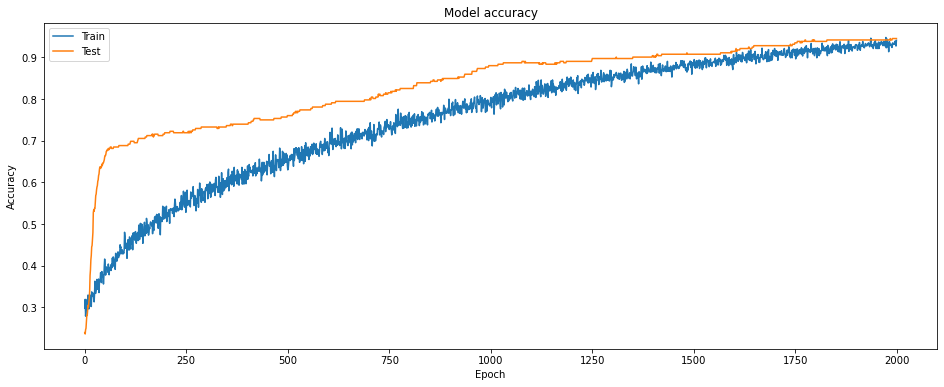

In [210]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

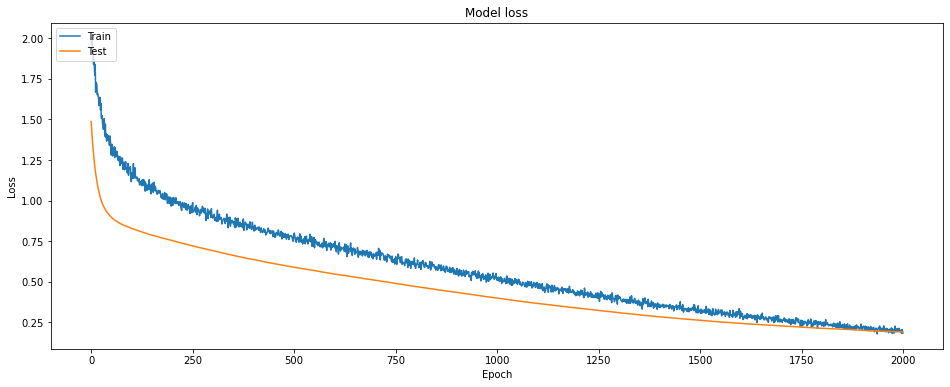

In [211]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

##### Feature Importances

###### XGBoost DNN

In [134]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [135]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.0001,0.001, 0.01, 0.02,0.1, 0.2, 0.3],
        'n_estimators': [100,200,500,1000]
        }

In [136]:
import datetime
from datetime import *

In [137]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [138]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [139]:
# param_comb = 5
# folds = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X_train, y_train)
# timer(start_time) # timing ends here for "start_time" variable

# # xgb.fit(X_train, y_train)




In [182]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)

In [212]:
##### CREATE XGB WITH OPTIMIZED PARAMS
# Best hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1.5, 'colsample_bytree': 0.8}

xgb = XGBClassifier(subsample= 0.8, features_names=X_train.columns, gamma=1.5, n_estimators =500, max_depth=7, min_child_weight=5, learning_rate= 0.2,colsample_bytree= 0.8 )
xgb.fit(X_train, y_train)


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:21:35] WARNING: ../src/learner.cc:541: 
Parameters: { features_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:21:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              features_names=Index(['AccBackMetres_ZoneS_1', 'AccBackMetres_ZoneS_2',
       'AccBackMetres_ZoneS_3', 'AccBackMetres_ZoneS_4',
       'AccBackMetres_ZoneS_5', 'AccBackMetres_ZoneS_6',
       'AccBackMetres_ZoneS_7', 'AccBackMetres_ZoneS_8',
       'AccBackMetres_ZoneS_9', 'AccBa...
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=7, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [213]:
# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 52.80%


In [214]:
# feat_imp = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')

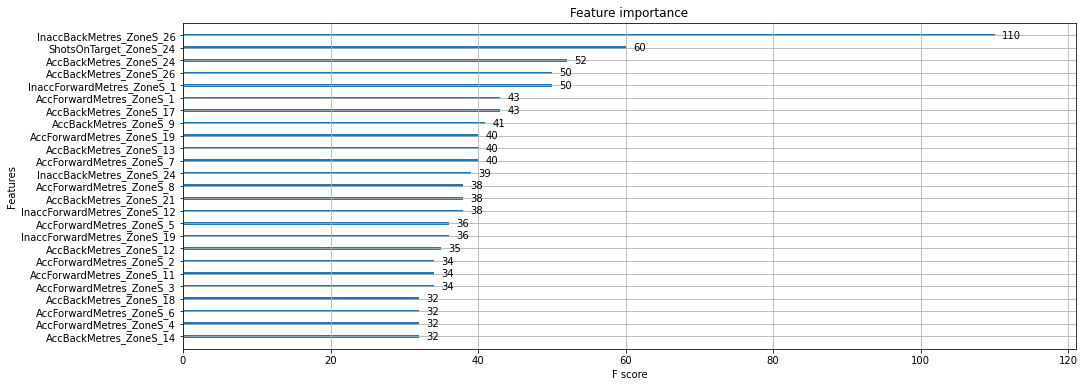

<Figure size 360x360 with 0 Axes>

In [215]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgb, max_num_features=25, ylabel="Features")
plt.figure(figsize=(5,5))
#fig.set_size_inches(6.5, 4.5, forward=True)
plt.show()

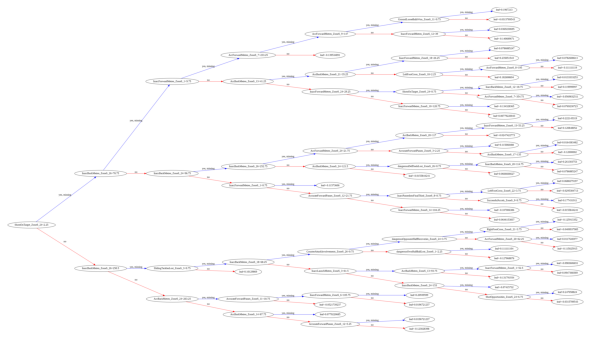

In [187]:
from xgboost import plot_tree
# plot single tree
plot_tree(xgb, num_trees=0, rankdir='LR')
#plt.rcParams['figure.figsize'] = [50, 20]
plt.show()

### Team Tactics and Automated Subs / Formation Shifts

In [146]:
from sklearn import preprocessing
from numpy import mean
from numpy import std

In [147]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [148]:
team_tactics = Player_Aggs_live60.groupby(['matchId', 'teamId']).sum().reset_index()
team_tactics.drop(["playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)


In [149]:
def team_result(team_df):
    
    df = pd.merge(team_df, Matches[["homeTeamId", "awayTeamId","matchId", "Result"]], how = "left", on = ["matchId"])
    
    # Classify Match W, L or D for a team
    conditions = [
        ((df['homeTeamId'] == df.teamId) &(df.Result==1)),
        ((df['homeTeamId'] == df.teamId)&(df.Result==0)),
        ((df['homeTeamId'] == df.teamId)&(df.Result==-1)),
        ((df['awayTeamId'] == df.teamId)&(df.Result==1)),
        ((df['awayTeamId'] == df.teamId)&(df.Result==0)),
        ((df['awayTeamId'] == df.teamId)&(df.Result==-1))
        ]

    # create a list of the values we want to assign for each condition
    values = [1,0,-1,-1,0,1]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['result'] = np.select(conditions, values)
    df.drop(["Result"], axis=1,inplace=True)
    return df

In [150]:
df = team_result(team_tactics)

df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

In [151]:
# df = pd.DataFrame(None, columns = team_tactics.columns)

# for team in teams:
#     test = team_tactics[team_tactics.teamId == team]
#     data = team_result(team, test)
#     df = df.append(data, ignore_index=True)

# df = df.replace([np.inf, -np.inf], np.nan)
# df = df.fillna(0)

In [152]:
df = df.loc[:, (df != 0).any(axis=0)]

In [153]:
df.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)

In [154]:
X_all = df.iloc[:,2:-1]
y_all = df.result.values

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)


In [156]:
rf = RandomForestClassifier(n_estimators = 500, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=123)

In [157]:
len(rf.feature_importances_)

1314

In [ ]:
### Determing player ratings for feature importance

df1 = Player_Aggs_live60.iloc[:,:15]
df2 = Player_Aggs_live60.iloc[:,15:]
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.fillna(0)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df2.values)
df2 = pd.DataFrame(x_scaled, columns = df2.columns)

base_imp = imp_df(df2.columns, rf.feature_importances_)
xxx = base_imp.transpose()
xxx.columns = xxx.iloc[0]
xxx = xxx.drop(xxx.index[[0]])
xxx = xxx.reindex(sorted(xxx.columns), axis=1)
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2.multiply(xxx.values)
negatives = df2.filter(regex='Inacc|Lost|Fouls|Fail|Not|Leaving').columns
df2[negatives] = df2[negatives].multiply(-1)
df2["sum"] = df2.iloc[:,:-1].sum(axis=1)
df2 = pd.concat([df1, df2], axis=1)
df2 = pd.merge(df2, df[["matchId", 'teamId', "result"]], on =['matchId', "teamId"], how = 'left' )
df2 = df2.loc[:, (df2 != 0).any(axis=0)]
df2['playerRatings']=  np.where(df2['gameTime (min)'] ==0, 0, df2['sum'])
df2['playerRatings'] = df2['playerRatings'].multiply(94 / float(df2.playerRatings.nlargest(5)[-1:]))
df2['playerRatings'] = np.where(df2['playerRatings'] > 94.0, 94, df2['playerRatings'])
df2.drop(["sum"], axis=1, inplace=True)
collections.Counter(df2.sort_values("playerRatings", ascending=False).iloc[0:100,:].Position)

In [ ]:
# inspecting player performance in a specific match for automated tactical sub recommendations (underperforming players)
df2[df2.matchId==2499725].sort_values("playerRatings", ascending=False)

In [ ]:
player_values = df2.sort_values("playerRatings", ascending=False)

In [ ]:
player_values.groupby(["shortName", 'playerId']).sum().reset_index().sort_values("playerRatings", ascending=False).head(40)



##### Feature Importance

In [ ]:
# inspecting feature importance from random forest
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=df2.iloc[:,15:-2].columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.head()tactical subs


In [ ]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)


In [ ]:
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(X_all.values)
# df = pd.DataFrame(x_scaled, columns = X_all.columns)


In [ ]:
a, b =X_train.columns, df2.columns
(a | b).difference(a & b)

##### Tactical sub in

In [ ]:
##### univariate regression
##### Identify opposition weakness in a match
##### Identify optimal player for tactical sub to replace our weak player and exploit their weakness
##### Identify formation that gives opposition toughest time (label formations below)

In [ ]:
df2.groupby(['matchId', 'teamId', "result"]).sum().reset_index().head(20)

In [ ]:
# calcualte team performance ratings 
df2['teamRatings'] = df2['playerRatings'].multiply(df2['gameTime (min)'])
team_perf = df2.groupby(['matchId', 'teamId']).sum().reset_index()
team_perf.drop(["Result","playerRatings","playerId", 'weight', 'height', 'xStart', 'yStart', 'homeTeamId', 'awayTeamId', 'gameTime (min)' ], axis = 1, inplace = True)
pd.merge(team_perf, 

In [ ]:
sns.boxplot(x="Result", y="teamRatings", data=team_perf);


In [ ]:
team_perf.head(20)

In [ ]:
##### WEAKNESSES (when they don't win)
X_all = result[((result.homeTeamId ==1612) &(result.Result!=1) | (result.awayTeamId==1612) &(result.Result!=-1))].iloc[:,:-1]
y_all = result[((result.homeTeamId ==1612) &(result.Result!=1) | (result.awayTeamId==1612) &(result.Result!=-1))].iloc[:,-1:]

In [ ]:
Player_Aggs3 = Player_Aggs_live50[Player_Aggs_live50.Position!="GKP"]
Player_Aggs3 = Player_Aggs3.loc[:, ~Player_Aggs3.columns.isin(["xStart","height","homeAway","yStart", "weight", "name","Result", 'matchId', 'homeTeamId', 'awayTeamId'])]

Player_Aggs3 = Player_Aggs3.groupby(['playerId' ,'teamId',]).sum().reset_index()

PV = Player_Aggs3.playerId
TV = Player_Aggs3.teamId

Player_Aggs3 = Player_Aggs3.iloc[:,2:].div(Player_Aggs3["gameTime (min)"], axis=0) *90
Player_Aggs3 = pd.concat([PV, TV, Player_Aggs3], axis =1)

# Player_Aggs3  = pd.merge(Player_Aggs2[["playerId","teamId"]], Player_Aggs3, how = 'left', on= 'playerId')
# Player_Aggs3 = Player_Aggs3.drop_duplicates()

Player_Aggs3.drop(["gameTime (min)"], inplace = True, axis =1)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


In [ ]:
df = Player_Aggs3[Player_Aggs3.teamId==1612]
df = df.fillna(0)
# df = Player_Aggs3.loc[:, ~Player_Aggs3.columns.isin(["homeAway","shortName", "name","Result", 'matchId', 'homeTeamId', 'awayTeamId', 'gameTime (min)'])]
# df = df[df.teamId==1609]
df.drop(['teamId'], axis=1, inplace=True)
df = df.replace([np.inf, -np.inf], np.nan).fillna(mean)

df_y  = pd.merge(df['playerId'], Players[["shortName", "playerId"]], how = 'left', on='playerId')[["shortName"]]
df_y = df_y.fillna("none")
y = df_y.values
X  = df.values



# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify=y)
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)
# print(knn.score(X_test, y_test)) # prints 0.87 - i.e. 87% accurate
# walcott = df[df.playerId==7879].drop('playerId', axis=1).values
# salah = df[df.playerId==120353].drop('playerId', axis=1).values
# print(knn.predict(walcott)) # prints ['midfield']
# print(knn.predict(salah))   # prints ['defence']

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'),labels=y)

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)
    print(len(counts))
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=8)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
Player_Aggs3[Player_Aggs3.playerId==7879] # walcott
Player_Aggs3[Player_Aggs3.playerId==120353] # salah

##### Own Team

In [ ]:
teamTest.loc[:, ~teamTest.columns.isin(["name","Result",'teamId', 'matchId', 'homeTeamId', 'awayTeamId', 'gameTime (min)'])]


In [ ]:
# import datetime
# while datetime.datetime.now().hour < 13:
#     x = 1+1

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(14,4)
# plt.subplot(121)
# sns.kdeplot(Events_England["xStart"], Events_England['yStart'], shade = True)
# plt.show()

In [ ]:
# # Function to transform match events into meaningul player performance profiles for machine learning
# def match_agg(eT, event_df):

#     df1 = pd.DataFrame(event_df[event_df["subEventName"]== eT ][['matchId', "teamId", "subEventName"]])
#     df1 = df1.groupby(['matchId','teamId']).size().to_frame(eT).reset_index()
#     df2 = df1.groupby('matchId').agg(['unique']).reset_index()
#     df3 = pd.DataFrame(None, columns = ['matchId', 'teamId', eT])
#     df3['matchId'], df3['teamId'], df3[eT] = df2.iloc[:, 0], df2.iloc[:,1], df2.iloc[:,2]
#     df4 = pd.concat([df3, pd.DataFrame(df3['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
#     result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')
#     result = pd.concat([result, pd.DataFrame(df3[eT].to_list(), columns=[eT+"1",eT+"2"])], axis=1, sort = False)
#     result = result.fillna(0) # handle na values where teams had no corners in a match

#     # fill in zeros to teams where there were no corners for a team
#     result[eT] = result[eT].apply(lambda row: list(row)+[0] if len(row)==1 else row)

#     # Correctly apply allocate home and away aggregate statistics to correct teams
#     result['home'+eT] = (
#         np.select(
#             condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
#             choicelist=[result[eT+"1"], result[eT+"2"]]))

#     result['away'+eT] = (
#         np.select(
#             condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
#             choicelist=[result[eT+"1"], result[eT+"2"]]))
    
#     # Create a column to recognize when a goal is scored
#     conditions = [
#         (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Success"))),
#         (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Failure") & (result['subEventName'] == "Shot"))),
#         (((result['subEventDescription'].str.match('goal ')) & (result['Result'] == "Failure") & (result['subEventName'] != "Shot")))
#         ]

#     # create a list of the values we want to assign for each condition
#     values = [1, 1, -1]

#     # create a new column and use np.select to assign values to it using our lists as arguments
#     result['Goal_Value'] = np.select(conditions, values, default = 0)
    
#     #result = result[result['playerId']!= 0]

#     # # drop useless columns that have been replaced
#     result.drop(['teamId', eT, "team1", "team2", eT+"1", eT+"2"], inplace = True, axis = 1 )
    
#     return result

In [ ]:
### Successful Vertical Yards Now Merge

# df = Events_England.loc[Events_England.Result == "Success" ].groupby(['matchId','playerId'])['attackMetres'].sum().reset_index()
# df2 = Events_England.loc[Events_England.Result == "Failure" ].groupby(['matchId','playerId'])['attackMetres'].sum().reset_index()

# with names, positions and clubs for reference
#df = pd.merge(Events_England.loc[Events_England.Result == "Success" ].groupby(['matchId','playerId'])['attackYards'].sum().reset_index(), Players[['playerId', 'shortName', "Position", 'clubName']], on = 'playerId').sort_values(by ='attackYards', ascending = False)
#df2 = pd.merge(Events_England.loc[Events_England.Result == "Failure" ].groupby(['matchId','playerId'])['attackYards'].sum().reset_index(), Players[['playerId', 'shortName', "Position", 'clubName']], on = 'playerId').sort_values(by ='attackYards', ascending = False)

# .sort_values(by ='attackYards', ascending = False)



In [ ]:
# dataframes of brute sum of attacking yard attempts without success or failure measures

#df  = pd.merge(Events_England.groupby(['matchId','playerId'])['attackYards'].agg(['sum']).reset_index(), Players[['playerId', 'shortName', "Position", 'clubName']], on ='playerId').sort_values(by ='sum', ascending = False).rename(columns={'sum':'attackYards'})
# df = Events_England.groupby(['matchId','playerId'])['attackYards'].agg(['sum']).reset_index().sort_values(by ='sum', ascending = False).rename(columns={'sum':'attackYards'})


In [ ]:
Player_Aggs = pd.merge(Player_Aggs, Matches[['matchId', "Result"]], how = 'left', on = 'matchId' )

#### Live match testing

##### Team Aggregates and Clustering Tactics

In [ ]:
dropcols = ['playerId',
'weight','height','xStart','yStart','homeTeamId','awayTeamId','gameTime (min)','FKCrossAccuracy','penaltiesConversion',
'low_left_save_efficiency','mid_left_save_efficiency','high_left_save_efficiency','low_center_save_efficiency',
'mid_center_save_efficiency','high_center_save_efficiency','low_right_save_efficiency','mid_right_save_efficiency',
'high_right_save_efficiency','shotAccuracy','shortPassAccuracy','longPassAccuracy','shortLongPassRatio',
'Result']

dropcols_live = dropcols[0:9]


In [ ]:
Team_Aggs_Matches = Player_Aggs.groupby(['matchId', 'teamId' ]).sum().reset_index()
Team_Aggs_Matches.drop(columns = dropcols, inplace=True, axis=1)
Team_Aggs_Matches = pd.merge(Team_Aggs_Matches, Matches[['matchId', "Country"]], on='matchId', how = 'left')
Teams['Country'] = [row['name'] for row in Teams.area]
Team_Aggs = Team_Aggs_Matches.groupby(['teamId']).sum().reset_index()
Team_Aggs.drop(columns = 'matchId', inplace=True, axis=1)
Team_Aggs = pd.merge(Team_Aggs, Teams[['teamId', 'Country']], how = 'left', on = 'teamId')

In [ ]:
Team_Aggs_Matches_live = Player_Aggs_live.groupby(['matchId', 'teamId' ]).sum().reset_index()
Team_Aggs_Matches_live.drop(columns = dropcols_live, inplace=True, axis=1)
Team_Aggs_Matches_live = pd.merge(Team_Aggs_Matches_live, Matches[['matchId', "Country"]], on='matchId', how = 'left')
Teams['Country'] = [row['name'] for row in Teams.area]
Team_Aggs_live = Team_Aggs_Matches_live.groupby(['teamId']).sum().reset_index()
Team_Aggs_live.drop(columns = 'matchId', inplace=True, axis=1)
Team_Aggs_live = pd.merge(Team_Aggs_live, Teams[['teamId', 'Country']], how = 'left', on = 'teamId')

In [ ]:
result = Matches_df(Team_Aggs_Matches, Team_Aggs)
result_live = Matches_df(Team_Aggs_Matches_live, Team_Aggs_live)
y_all = result["Result"].values

In [ ]:
X_all_live = result_live.loc[:, ~result_live.columns.isin(["awayCounterAttackGoal", 
                                                           "Result",'teamId', 'matchId', 'homeTeamId', 
                                                           'awayTeamId', 'homeGoal_Value','awayGoal_Value', 
                                                           'awayCornerAssists', 'awayPenaltyNotScored', 'homeCornerAssists'])]
    

In [ ]:
X_all = result.loc[:, ~result.columns.isin(['teamId', 'matchId', 'homeTeamId', 'awayTeamId', 'awayGoal_Value','homegoalsAllowed', 'awaygoalsAllowed'
                                           ,'homeGoal_low_left', 'homeGoal_mid_left', 'awayGoal_mid_right',
                                           'homeGoal_Value', 'homeCrossAssists', 'homeCornerAssists',
                                           'homeGoal_low_center', 'homeTotalAssists','homeRightFootGoal', 'awayRightFootGoal'
                                           ,'homeRightFootGoal', 'awayRightFootGoal',
       'homeLeftFootGoal', 'awayLeftFootGoal', 'homeTotalAssists',
       'awayTotalAssists',"Result", 'awayGoal_low_left', 'awayGoal_low_center',
       'homeGoal_low_right', 'awayGoal_low_right','homeHeader/Body_Goal', 'awayHeader/Body_Goal','awayCrossAssists',
                                           'awayCrossAssists','awayInterceptionGoal',
 'homeInterceptionGoal','awayOwnGoals','homeFKCrossAssists', 'homeGoal_high_left','awayFKCrossAssists',
 'homeOwnGoals','homeGoal_high_right','awayGoal_high_center',
 'awayGoal_high_left','awayInterceptionGoal','homeInterceptionGoal','awayOwnGoals','awayPenaltyNotScored',
 'homeFKCrossAssists','homeGoal_high_left','awayFKCrossAssists',
'awayGoal_mid_left', 'homeGoal_mid_right','homeGoal_mid_center','awayGoal_high_right','awayGoal_mid_center',
 'homeGoal_high_center','awayCornerAssists','homeOwnGoals', 'homeGoal_high_right','awayGoal_high_center'                                      
 'awayGoal_high_left', 'homeCounterAttackGoal', 'awayCounterAttackGoal'])]


In [ ]:
X_all_live = X_all_live.replace([np.inf, -np.inf], np.nan)
X_all_live = X_all_live.fillna(X_all_live.mean())
X_train_live, X_test_live, y_train_live, y_test_live = train_test_split(X_all_live, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)


### Experiment: Extracting features of team playing style using Random Forests

In [ ]:
# param_grid = {
#     'n_estimators': [200,400,500, 700,1000,2000]
# }

#### Subset AKA live match trials

In [ ]:
X_all = X_all.replace([np.inf, -np.inf], np.nan)
X_all = X_all.fillna(X_all.mean())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, shuffle=True, test_size= 0.2, train_size=0.8, random_state=3)


In [ ]:
clf = RandomForestClassifier(n_estimators = 1000, random_state=3)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
# CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 10)

In [ ]:
# CV_rfc.fit(X_train, y_train)

In [ ]:
# CV_rfc.best_estimator_

In [ ]:
labels = [-1,0,1]
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, labels = labels))
print('accuracy score: {0:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
idx = list(clf.feature_importances_.argsort()[0:25])
col = list(X_train.columns[idx])
# modelname.feature_importance_
y = clf.feature_importances_[0:25]
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [ ]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual Result'], colnames=['Predicted Result']))
class_name = list(set(y_test))
print(class_name)

In [ ]:


# estimator_nonlimited = clf.estimators_[5]
# fn = list(X_train.columns)
# # from sklearn.tree import export_graphviz
# # export_graphviz(estimator_limited, out_file='tree_limited.dot', feature_names = iris.feature_names,
# #                 class_names = iris.target_names,
# #                 rounded = True, proportion = False, precision = 2, filled = True)

# export_graphviz(estimator_nonlimited, out_file='tree_nonlimited.dot', feature_names = fn,
#                 class_names = ["W", "L", 'D'],
#                 rounded = True, proportion = False, precision = 2, filled = True)


# import pydot

# (graph,) = pydot.graph_from_dot_file('tree_nonlimited.dot')
# graph.write_png('tree_nonlimited.png')
# graph.draw('tree_nonlimited.png')


# # !dot -Tpng tree_limited.dot -o tree_nonlimited.png -Gdpi=600
# # from IPython.display import Image
# # Image(filename = 'tree_nonlimited.png')



In [ ]:
from dtreeviz.trees import *
import dtreeviz
from IPython.core.display import display, HTML
from dtreeviz.trees import dtreeviz

fn = list(X_train.columns)
cn = [-1,0,1]

dtree = tree.DecisionTreeClassifier(random_state=0)
dtree = dtree.fit(X_train, y_train)
viz = dtreeviz(dtree,
               X_train,
               y_train,
               feature_names=fn, 
               class_names=cn,
               fancy=False)

display(HTML(viz.svg()))

In [ ]:
y_predict_proba = clf.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
all_y_test_i = np.array([])
all_y_predict_proba = np.array([])
for i in [-1,0,1]:
    y_test_i = list(map(lambda x: 1 if x == i else 0, list(y_test)))
    if len(all_y_test_i) >0:
        all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
    else:
        all_y_test_i = y_test_i
    all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
    fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
roc_auc["average"] = auc(fpr["average"], tpr["average"])


# Plot average ROC Curve
plt.figure()
plt.plot(fpr["average"], tpr["average"],
         label='Average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["average"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot each individual ROC curve
for i in [-1,0,1]:
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# generate a no skill prediction (majority class)
# ns_probs = [0 for _ in range(len(y_test))]
# ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
# plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

# #Now calculate the AUC for each class separately

y_predict_proba = clf.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
all_y_test_i = np.array([])
all_y_predict_proba = np.array([])

WDL = ["Draw","Home Win", "Home Loss"]

for pp in [-1,0,1]:
    fpr, tpr, thresholds = metrics.roc_curve(y_test,  
                     clf.predict_proba(X_test)[:,pp], pos_label = pp)
    plt.plot(fpr, tpr,  marker='.', label= WDL[pp])
    auroc = round(metrics.auc(fpr, tpr),2)
    print('RF',WDL[pp],'--AUC--->',auroc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()



In [ ]:
n_matches = Matches.shape[0]
n_features = Matches.shape[1] -1
n_homewins =  len(Matches[Matches.Result==1])
win_rate = (float(n_homewins) / (n_matches)) * 100
n_homeloss =  len(Matches[Matches.Result==-1])
loss_rate = (float(n_homeloss) / (n_matches)) * 100
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print('Number of matches won by home side: {}'.format(n_homewins))
print('Win rate of home team {:2f}%'.format(win_rate))
print('Loss rate of home team {:2f}%'.format(loss_rate))
print(collections.Counter(Matches.Result))

In [ ]:
dropcols = [
 'playerId',
 'weight',
 'height',
 'xStart',
 'yStart',
 'homeTeamId',
 'awayTeamId',
 'gameTime (min)',
#  'AccurateAttackMetres',
#  'InaccurateAttackMetres',
#  'Goal_Value',
#  'SimulationFouls',
#  'FoulsCommited',
#  'Clearances',
#  'AccLaunchMetres',
#  'InaccLaunchMetres',
#  'FKKeyCross',
#  'FKCrossAssists',
 'FKCrossAccuracy',
 'penaltiesConversion',
#  'dangerousOpponentHalfRecoveries',
#  'dangerousOwnHalfBallLost',
#  'dangerousDefDuelsLost',
 'low_left_save_efficiency',
 'mid_left_save_efficiency',
 'high_left_save_efficiency',
 'low_center_save_efficiency',
 'mid_center_save_efficiency',
 'high_center_save_efficiency',
 'low_right_save_efficiency',
 'mid_right_save_efficiency',
 'high_right_save_efficiency',
#  'goalsAllowed',
#  'GkSaves',
#  'AccurateHandPass',
#  'InaccurateHandPass',
#  'GKLeavingLineInstance',
#  'SuccessfulAccels',
#  'FailedAccels',
#  'CumAccelerationDist',
#  'AccelsDistIntoFinal3rd',
#  'AccelsDistWithinFinal3rd',
#  'CrossAssists',
#  'RightFootCross',
#  'LeftFootCross',
#  'CrossKeyPass',
#  'AccCrosses',
#  'InaccCrosses',
#  'AccCrossesIntoBox',
#  'InaccCrossesIntoBox',
#  'SlidingTacklesWon',
#  'SlidingTacklesLost',
#  'GroundDefDuelsWon',
#  'GroundDefDuelsLost',
#  'DefensiveAnticipations',
#  'GroundLooseBallsWon',
#  'GroundLooseBallsLost',
#  'GroundAttackDuelsWon',
#  'GroundAttackDuelsLost',
#  'OffensiveTouchesBox',
#  'Goal_low_left',
#  'Goal_mid_left',
#  'Goal_high_left',
#  'Goal_low_center',
#  'Goal_mid_center',
#  'Goal_high_center',
#  'Goal_low_right',
#  'Goal_mid_right',
#  'Goal_high_right',
 'shotAccuracy',
#  'ShotsOnTarget',
#  'ShotsOffTarget',
#  'ShotOpportunities',
#  'FreeKickShotAcc',
#  'FreeKickShotInacc',
#  'PenaltyNotScored',
#  'Header/Body_Goal',
#  'RightFootGoal',
#  'LeftFootGoal',
#  'CounterAttackGoal',
#  'InterceptionGoal',
#  'OwnGoals',
#  'AerialDuelsWon',
#  'AerialDuelsLost',
 'shortPassAccuracy',
 'longPassAccuracy',
 'shortLongPassRatio',
#  'InaccPassesWithinFinalThird',
#  'AccPassesWithinFinalThird',
#  'AccPassesIntoFinalThird',
#  'InaccPassesIntoFinalThird',
#  'AccThroughsIntoFinalThird',
#  'InaccurateSmartPasses',
#  'AccurateSmartPasses',
#  'InaccurateThroughPasses',
#  'AccurateThroughPasses',
#  'AccurateKeyPasses',
#  'InaccurateKeyPasses',
#  'TotalAssists',
#  'CounterAttackInvolvements',
#  'PassLostDangerous',
#  'CounterAttackIntercept',
#  'SuccessfulInterceptions',
#  'InaccurateForwardPasses',
#  'AccurateForwardPasses',
#  'CornerAssists',
#  'CornerOpportunitiesCreated',
#  'SuccessfulCorners',
#  'FailedCorners',
 'Result']

##### KMeans for detecting and visualizing team formations

In [ ]:
# live adaptable formation
def team_formation(event_df, teamId, matchId):
    event_df = event_df[(event_df.teamId==teamId)&(event_df.matchId==matchId)]
    maxtime = event_df.eventSec.max()
    if maxtime > 1200:
        mintime = maxtime - 1200 # last 20mins of match data for formation revelation
    else:
        mintime = 0
    x1 = np.array(event_df[(event_df.eventSec > mintime)].xStart) 
    x2 = np.array(event_df[(event_df.eventSec > mintime)].yStart)
    X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) 
    return x1, x2, X

In [ ]:
#Creating the data 
x1, x2, X = team_formation(Events_England, 1609, 2499719)


In [ ]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 7)
ax=fig.add_subplot(1,1,1)

# pitch borderline and centrer line
plt.plot([0,0],[0,100], color="black")
plt.plot([0,100],[100,100], color="black")
plt.plot([100,100],[100,0], color="black")
plt.plot([100,0],[0,0], color="black")
plt.plot([50,50],[0,100], color="black") # center line

# left penalty area
plt.plot([16.5,16.5],[75,25],color="black")
plt.plot([0,16.5],[75,75],color="black")
plt.plot([16.5,0],[25,25],color="black")

#Right Penalty Area
plt.plot([83.5,100],[75,75],color="black")
plt.plot([83.5,83.5],[75,25],color="black")
plt.plot([83.5,100],[25,25],color="black")

#Left 6-yard Box
plt.plot([0,5.5],[64,64],color="black")
plt.plot([5.5,5.5],[64,36],color="black")
plt.plot([5.5,0.5],[36,36],color="black")

#Right 6-yard Box
plt.plot([100,94.5],[64,64],color="black")
plt.plot([94.5,94.5],[64,36],color="black")
plt.plot([94.5,100],[36,36],color="black")

#Prepare Circles
centreCircle = plt.Circle((50,50),9.15,color="black",fill=False)
centreSpot = plt.Circle((50,50),0.6,color="black")
leftPenSpot = plt.Circle((11,50),0.6,color="black")
rightPenSpot = plt.Circle((89,50),0.6,color="black")

# zones
plt.plot([100,0],[25,25],color="black", linestyle='--') 
plt.plot([100,0],[75,75],color="black", linestyle='--') 
plt.plot([100,0],[25,25],color="black", linestyle='--') 
plt.plot([33,33],[75,25],color="black", linestyle='--')
plt.plot([67,67],[75,25],color="black", linestyle='--')
plt.plot([33,33],[100,75],color="black", linestyle='--')
plt.plot([16.5,16.5],[100,75],color="black", linestyle='--')
plt.plot([67,67],[100,75],color="black", linestyle='--')
plt.plot([83.5,83.5],[100,75],color="black", linestyle='--')
plt.plot([33,33],[0,25],color="black", linestyle='--')
plt.plot([16.5,16.5],[0,25],color="black", linestyle='--')
plt.plot([67,67],[0,25],color="black", linestyle='--')
plt.plot([83.5,83.5],[0,25],color="black", linestyle='--')
plt.plot([16.5,83.5],[50,50],color="black", linestyle='--')
plt.plot([33,33],[0,25],color="black", linestyle='--')
plt.plot([0,16.5],[64,64],color="black", linestyle='--')
plt.plot([0,16.5],[36,36],color="black", linestyle='--')
plt.plot([83.5,100],[64,64],color="black", linestyle='--')
plt.plot([83.5,100],[36,36],color="black", linestyle='--')

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

#Prepare Arcs
leftArc = Arc((11,50),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((89,50),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

# #Tidy Axes
# plt.axis('off')

# K-Means Live formation
# plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=20, cmap='viridis')
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Heat Map of Player and Action Type
# team = Events_England[(Events_England.teamId == 1612)  & (Events_England.subEventName=="Shot") ]
# sns.kdeplot(team["xStart"],team["yStart"], shade=True)

plt.ylim(100, 0)
plt.xlim(0, 100)




In [ ]:
#Creating the data 
x1 = np.array(Player_Aggs[Player_Aggs['gameTime (min)']>45].xStart) 
x2 = np.array(Player_Aggs[Player_Aggs['gameTime (min)']>45].yStart)
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) 

In [ ]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

In [ ]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [ ]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [ ]:
# This is what four pitch area location clusters look like

In [ ]:

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
#### Traditional 11 pitch positions

In [ ]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
kmeans = KMeans(n_clusters=22)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Comparing Two Teams in a head to head

In [ ]:
Teams[Teams["name"].str.contains('Barcelona')]

In [ ]:
#Creating the data
manUtdBad = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==1611) &(((Player_Aggs.homeAway=="home") & (Player_Aggs.Result==-1)) | ((Player_Aggs.homeAway=="away") & (Player_Aggs.Result==1)))]
manUtdGood = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==1611) &(((Player_Aggs.homeAway=="home") & (Player_Aggs.Result==1)) | ((Player_Aggs.homeAway=="away") & (Player_Aggs.Result==-1)))]
liverpoolGood = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==1612) &(((Player_Aggs.homeAway=="home") & (Player_Aggs.Result==1)) | ((Player_Aggs.homeAway=="away") & (Player_Aggs.Result==-1)))]
liverpoolBad = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==1612) &(((Player_Aggs.homeAway=="home") & (Player_Aggs.Result==-1)) | ((Player_Aggs.homeAway=="away") & (Player_Aggs.Result==1)))]
barcelonaBad = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==676) &(((Player_Aggs.homeAway=="home") & (Player_Aggs.Result==-1)) | ((Player_Aggs.homeAway=="away") & (Player_Aggs.Result==1)))]
barcelonaGood = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==676) &(((Player_Aggs.homeAway=="home") & (Player_Aggs.Result==1)) | ((Player_Aggs.homeAway=="away") & (Player_Aggs.Result==-1)))]


x1 = np.array(manUtdBad.xStart) 
x2 = np.array(manUtdBad.yStart)
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) 

In [ ]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers2 = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
x1 = np.array(manUtdGood.xStart) 
x2 = np.array(manUtdGood.yStart)
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) 


In [ ]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
# plt.scatter(centers2[:, 0], centers2[:, 1], c='red', s=200, alpha=0.5)


In [ ]:
manUtd = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==1611)]
barca = Player_Aggs[(Player_Aggs['gameTime (min)']>45) & (Player_Aggs.teamId ==676)]       

In [ ]:
## Man Utd
x1 = np.array(manUtd.xStart) 
x2 = np.array(manUtd.yStart)
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) 

kmeans = KMeans(n_clusters=11)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
## Barcelona
x1 = np.array(barca.xStart) 
x2 = np.array(barca.yStart)
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2) 

kmeans = KMeans(n_clusters=11)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
# Events_England = pd.read_csv('eventsEvents_England_processed')

In [ ]:
# Player_Aggs_live = pd.read_csv('eventsPlayer_Aggs_live.csv')
# Player_Aggs = pd.read_csv('eventsPlayer_Aggs.csv')

In [ ]:
# Player_Aggs_live.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
# def Matches_df_fDNN(TAM, TA):
    
#     df2 = TAM.groupby('matchId').agg(list).reset_index()
#     df2.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)
#     df3 = pd.DataFrame(None, columns = list(TA.columns))

#     for index, col in enumerate(list(TAM.columns)):
#         df3[col] = df2.iloc[:,index]

#     df4 = pd.concat([df3, pd.DataFrame(df3['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
#     result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')
#     #df4.drop(["Country"], axis=1, inplace=True)

#     for var in list(result.columns)[2:-5]:
#         result = pd.concat([result, pd.DataFrame(df3[var].to_list(), columns=["1_" + var, "2_" + var])], axis=1, sort = False)

#         # Correctly apply allocate home and away aggregate statistics to correct teams
#         result['home'+var] = (
#             np.select(
#                 condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
#                 choicelist=[result["1_" + var], result["2_" + var]]))

#         result['away'+var] = (
#             np.select(
#                 condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
#                 choicelist=[result["1_" + var], result["2_" + var]]))

#         # # drop useless columns that have been replaced
#         result.drop([ var, "1_" + var, "2_" + var], inplace = True, axis = 1 )

#     # # drop useless columns that have been replaced
#     result.drop(['teamId',"team1", "team2"], inplace = True, axis = 1 )
#     result = pd.merge(result, Matches[['matchId', "Result"]], on='matchId', how = 'left')
#     return result

In [ ]:
# def Matches_df(TAM, TA):
    
#     df2 = TAM.groupby('matchId').agg(list).reset_index()
#     df2.drop(["homeTeamId", "awayTeamId"], inplace=True, axis=1)
#     df3 = pd.DataFrame(None, columns = list(TA.columns))

#     for index, col in enumerate(list(TAM.columns)):
#         df3[col] = df2.iloc[:,index]

#     df4 = pd.concat([df3, pd.DataFrame(df3['teamId'].to_list(), columns=['team1','team2'])], axis=1, sort = False)
#     result = pd.merge(df4, Matches[['matchId', "homeTeamId", "awayTeamId"]], on='matchId', how='inner')
#     #df4.drop(["Country"], axis=1, inplace=True)

#     for var in list(result.columns)[1:-6]:
#         result = pd.concat([result, pd.DataFrame(df3[var].to_list(), columns=[var+"1",var+"2"])], axis=1, sort = False)

#         # Correctly apply allocate home and away aggregate statistics to correct teams
#         result['home'+var] = (
#             np.select(
#                 condlist=[result['team1'] == result['homeTeamId'], result['team2'] == result['homeTeamId']], 
#                 choicelist=[result[var+"1"], result[var+"2"]]))

#         result['away'+var] = (
#             np.select(
#                 condlist=[result['team1'] == result['awayTeamId'], result['team2'] == result['awayTeamId']], 
#                 choicelist=[result[var+"1"], result[var+"2"]]))

#         # # drop useless columns that have been replaced
#         result.drop([ var, var+"1", var+"2"], inplace = True, axis = 1 )

#     # # drop useless columns that have been replaced
#     result.drop(['teamId',"team1", "team2"], inplace = True, axis = 1 )
#     result = pd.merge(result, Matches[['matchId', "Result"]], on='matchId', how = 'left')
#     return result

In [ ]:
# #### ORIGINAL

# dropcols = ['playerId',
# 'weight','height','xStart','yStart','homeTeamId','awayTeamId','gameTime (min)','penaltiesConversion',
# 'low_left_save_efficiency','mid_left_save_efficiency','high_left_save_efficiency','low_center_save_efficiency',
# 'mid_center_save_efficiency','high_center_save_efficiency','low_right_save_efficiency','mid_right_save_efficiency',
# 'high_right_save_efficiency','shotAccuracy','shortPassAccuracy','longPassAccuracy','shortLongPassRatio',
# 'Result'][0:7]

# dropcols_live =  dropcols[0:7]

# Team_Aggs_Matches = Player_Aggs2.groupby(['matchId', 'teamId' ]).sum().reset_index()
# Team_Aggs_Matches.drop(columns = dropcols, inplace=True, axis=1)

# Team_Aggs = Team_Aggs_Matches.groupby(['teamId']).sum().reset_index()
# Team_Aggs.drop(columns = ['matchId'], inplace=True, axis=1)


In [ ]:
# We performed this and found our best params which are used in the model above

In [ ]:
##### RANDOM FORESTS WITh GRIDSEARCH

from sklearn.model_selection import StratifiedKFold

In [ ]:
# # summarize results

# print("best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
idx = list(clf.feature_importances_.argsort()[0:25])
col = list(X_train.columns[idx])

# modelname.feature_importance_

y = clf.feature_importances_[0:25]

# plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [ ]:
df1 = Player_Aggs_live30.iloc[:,:15]
df2 = Player_Aggs_live30.iloc[:,15:]
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.fillna(0)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df2.values)
df2 = pd.DataFrame(x_scaled, columns = df2.columns)

base_imp = imp_df(df2.columns, rf.feature_importances_)
xxx = base_imp.transpose()
xxx.columns = xxx.iloc[0]
xxx = xxx.drop(xxx.index[[0]])
xxx = xxx.reindex(sorted(xxx.columns), axis=1)
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2.multiply(xxx.values)
df2[negatives] = df2[negatives].multiply(-1)
df2["sum"] = df2.sum(axis=1)
df2 = pd.concat([df1, df2], axis=1)
df2 = pd.merge(df2, df[["matchId", 'teamId', "Result"]], on =['matchId', "teamId"], how = 'left' )
#df2 = df2.loc[:, (df2 != 0).any(axis=0)]
df2['playerRatings']=  np.where(df2['gameTime (min)'] ==0, 0, df2['sum'])
df2['playerRatings'] = df2['playerRatings'].multiply(94 / df2.playerRatings.max())
df2.drop(["sum"], axis=1, inplace=True)
collections.Counter(df2.sort_values("playerRatings", ascending=False).iloc[0:100,:].Position)

In [ ]:
from dtreeviz.trees import *
import dtreeviz
from IPython.core.display import display, HTML
from dtreeviz.trees import dtreeviz

fn = list(X_all.columns)
cn = [-1,0,1]

_ = tree.plot_tree(clf.estimators_[0], feature_names=X_all.columns, filled=True, max_depth=10)
